<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px" width="50">

# Capstone Project: Predicting Stock Price Changes of  Healthcare Companies based on News Headlines

### Contents:
#### Part 2 of 3 
- Executive Summary
- Problem Statement
- Background
- Data
- [Data Munging](#Data-Munging)
- [Exploratory Data Analysis & Visualisation](#Exploratory-Data-Analysis-&-Visualisation)
- Modelling
- Results & Analysis
- Recommendations & Conclusions
- References

Other Notebooks: [Part 1 of 3](01-Introduction.ipynb) | [Part 3 of 3](03-Model-&-Analysis.ipynb) | [Annex - News WebScraping](Annex_Webscraping.ipynb) | [Annex - Further Scraping & Cleaning](Annex_Webscraping_and_Cleaning_Headlines.ipynb)

## Data Munging

### Import libraries & data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib_venn import venn2,venn2_circles
import seaborn as sns
import csv
import random
import collections
import itertools

import re
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
wn = nltk.WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from pattern.en import ngrams, lemma
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
plt.style.use('_classic_test_patch')
pd.set_option('display.max.columns', None)
pd.set_option('display.max.colwidth', 100)

In [2]:
# import csv file as dataframe
df = pd.read_csv('../assets/merged_headlines.csv')

In [3]:
# create feature to indicate if stock price is positive or negative
def direction(price):
    if price > 0:
        return "positive"
    elif price < 0:
        return "negative"
    else:
        return "constant"

In [4]:
# apply function to price change column
df['adj_direction'] = df['adjusted'].apply(direction)

In [5]:
# look at the number of observations with positive and negative stock price changes within a day
df['adj_direction'].value_counts()

negative    1907
positive    1895
constant       1
Name: adj_direction, dtype: int64

In [6]:
df.drop(columns=['pct_px_change', 'abs_pct_change', '5d_change', '5d_abs', 'adjusted_5d', 'adjusted_5d_abs'],
        inplace=True)

In [7]:
df.dropna(inplace=True)

In [8]:
df.isna().sum()

volume           0
date             0
adjusted         0
adjusted_abs     0
text             0
news_count       0
adj_direction    0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3802 entries, 0 to 3802
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   volume         3802 non-null   int64  
 1   date           3802 non-null   object 
 2   adjusted       3802 non-null   float64
 3   adjusted_abs   3802 non-null   float64
 4   text           3802 non-null   object 
 5   news_count     3802 non-null   int64  
 6   adj_direction  3802 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 237.6+ KB


In [10]:
df.head()

volume        date  adjusted  adjusted_abs  \
0   29067200  2012-01-13 -0.164794      0.164794   
1  132872800  2012-01-27 -0.647985      0.647985   
2   55526800  2012-01-31 -0.796045      0.796045   
3   37375900  2012-02-07  0.224445      0.224445   
4   25262900  2012-02-14  0.266436      0.266436   

                                                                                                  text  \
0                                                ['Nestle declines comment on Pfizer unit bid report']   
1                                              ["US FDA approves Pfizer\\'s Inlyta for kidney cancer"]   
2    ['Generics take toll on Pfizer, Lilly profits', 'Pfizer trims 2012 view, citing stronger dollar']   
3  ["India\\'s Pfizer to spin-off animal healthcare business", "Dealtalk: Nestle in lead to scoop u...   
4  ["Pfizer says its drug is best hope for Alzheimer\\'s", "Pfizer says its drug is best hope vs. A...   

   news_count adj_direction  
0           1      negative  
1           1      negative  
2           2      negative  
3           3      positive  
4           2      positive

## Data Cleaning
### Text data cleaning - remove punctuations, stopwords, lemmatization

In [11]:
# print unique headlines for each column
for item in range(0,len(df.text.unique())):
    print(df.text.unique()[item], "\n")

['Nestle declines comment on Pfizer unit bid report'] 

["US FDA approves Pfizer\\'s Inlyta for kidney cancer"] 

['Generics take toll on Pfizer, Lilly profits', 'Pfizer trims 2012 view, citing stronger dollar'] 

["India\\'s Pfizer to spin-off animal healthcare business", "Dealtalk: Nestle in lead to scoop up Pfizer\\'s baby formula unit", "DEALTALK-Nestle in lead to scoop up Pfizer\\'s baby formula unit"] 

["Pfizer says its drug is best hope for Alzheimer\\'s", "Pfizer says its drug is best hope vs. Alzheimer\\'s"] 

['Pfizer eyes tie-ups with more Chinese drugmakers'] 

['Mead, Danone vie vs Nestle for Pfizer unit: sources', 'Mead, Danone vie vs Nestle for Pfizer unit-sources'] 

['Mead-Danone to fight Nestle for Pfizer unit-sources'] 

['Pfizer buys vitamin C maker Emergen-C brands'] 

['Pfizer recalls expired lot of Prevnar vaccine'] 

["Durect\\'s partner Pfizer to end pain drug deal"] 

['Nestle and Danone-Mead to battle for Pfizer unit'] 

['Bayer, Novartis mull Pfizer animal 

['FEATURE-Pfizer takes its shot at a vaccine for evasive superbug', 'RPT-FEATURE-Pfizer takes its shot at a vaccine for evasive superbug'] 

['Teva, Sun Pharma to pay $2.15 bln to settle Pfizer patent suit', 'Pfizer settles patent lawsuit with Teva, Sun Pharma for $2.15 bln'] 

['Pfizer says shareholders snap up remaining Zoetis shares'] 

['Pfizer, Novartis may join Amgen in bidding for Onyx: sources'] 

['Pfizer gets EU approval for wider use of Prevenar vaccine', 'REFILE-Pfizer gets EU approval for wider use of Prevenar vaccine'] 

['Pfizer gets fresh cancer drug rejection from UK cost body'] 

['Pfizer not to move forward with takeover bid for Onyx -sources'] 

['Pfizer to split generic, branded drugs units', 'Pfizer to internally split its generic, branded drugs operations'] 

['Pfizer settles U.S. marketing case related to Rapamune', 'Pfizer earnings top estimates, reiterates forecast', 'Pfizer settles U.S. marketing case dating to Wyeth conduct', 'Pfizer income beats estimates, 

['AstraZeneca results to get lift from bid foe Pfizer'] 

["Pfizer\\'s need for deal looms larger with earnings report"] 

['Pfizer beats forecasts as oncology drugs grow', 'Pfizer leaves investors guessing on intentions for Astra', 'Pfizer says looking at other deals, declines comment on interest in AstraZeneca'] 

["Pfizer to buy Baxter\\'s vaccines unit for $635 mln", "Pfizer to buy Baxter\\'s vaccines unit for $635 million", 'CORRECTED-Pfizer to buy two Baxter vaccines for $635 mln'] 

['AstraZeneca raises forecasts after seeing off Pfizer', 'Astra CEO says Nov. 18 investor day to focus on progress, no comment on Pfizer', 'AstraZeneca smashes forecasts in Q2 after seeing off Pfizer'] 

['Pfizer bid for GSK \\\\"has some merits\\\\', 'CORRECTED-Pfizer says threats to managers force staff lockout at Mumbai factory', 'Pfizer says threats to managers force staff lockout at Mumbai factory'] 

['Pfizer reaches $35 mln settlement over marketing of Rapamune', 'Pfizer to pay $35 mln to U.S.

['RPT-Pfizer-Allergan sparks fresh tax inversion angst on Capitol Hill'] 

['Factbox: Pfizer-Allergan puts focus on U.S. tax inversion rules'] 

['Pfizer partners with South Africa to produce pneumococcal vaccine', 'GSK boss silent on report drugmaker rebuffed Pfizer'] 

['Merck KGaA, Pfizer widen development of cancer immunology drug'] 

['After big spending and hard lobbying, Pfizer eyes new tax home', 'RPT-After big spending and hard lobbying, Pfizer eyes new tax home', 'Pfizer-Allergan deal would set up U.S. company for a split', 'RPT-Pfizer-Allergan deal would set up US company for a split'] 

['Pfizer-Allergan deal refocuses market on U.S. tax-inversion rules', 'Pfizer-Allergan deal refocuses market on US tax-inversion rules'] 

['INSIGHT-How Pfizer has shifted U.S. profits overseas for years', 'Exclusive: Moelis clinches Pfizer advisory role with help from Eric Cantor - sources', 'How Pfizer has shifted U.S. profits overseas for years'] 

['RPT-INSIGHT-How Pfizer has shifted U.S

['Spark Therapeutics and Pfizer announce data from first cohort in Hemophilia B Phase 1\\\\/2 trial', "Bind Therapeutics says two bidders join Pfizer\\'s stalking horse bid"] 

["Exclusive: Teva, Mylan eye Pfizer\\'s Brazil venture, sources say", "Bind Therapeutics determines Pfizer\\'s $40 mln bid highest"] 

['Pfizer and Western Oncolytics announce immuno-oncology research collaboration', 'Bind Therapeutics says it entered into an asset purchase agreement with Pfizer', 'Pfizer announces positive top-line results from Phase 3 Maintenance Trial of Oral XELJANZ'] 

['Sanofi, Pfizer, Gilead & Celgene interested in Medivation - CNBC citing sources'] 

['Pfizer acquires Bamboo Therapeutics to beef up gene therapy arsenal'] 

['Pfizer in $486 mln settlement of Celebrex, Bextra litigation', 'Pfizer says to decide by year end on potential split of company', 'UPDATE 5-Pfizer beats estimates, but branded drugs disappoint', 'Pfizer Q2 adjusted EPS $0.64', 'Pfizer in $486 million settlement of Ce

['BioInvent enters research collaboration, issues new shares to Pfizer'] 

['AstraZeneca completes sale of antibiotics business to Pfizer', 'Pfizer completes acquisition of small molecule anti-infective business from AstraZeneca'] 

['Growth hormone deficiency drug from OPKO and Pfizer fails study'] 

['Absorption Systems announces a technology licensing agreement with Pfizer', 'Spark Therapeutics announces $15 mln milestone payment from pfizer', 'Pfizer escapes Lipitor MDL as diabetes link fails'] 

['Pfizer announces positive top-line results from study for potential Humira biosimilar'] 

['Pfizer enters into delegation of authority with Astrazeneca Pharma India'] 

['Pfizer reports positive top-line results from phase 2 study of investigational clostridium difficile vaccine'] 

['Pfizer receives positive CHMP opinion in Europe for Xeljanz'] 

['Pfizer Ltd Dec-qtr profit up about 4 pct'] 

["Pfizer\\'s Q4 Lyrica IH revenue was $1.06 bln vs $955 mln yr ago", 'Pfizer sees 2017 Prevnar 

['CORRECTED-Pfizer, Astellas prostate cancer drug clears late-stage trial', 'Pfizer, Astellas prostate cancer drug promising in late-stage trial', 'Astellas Pharma and Pfizer say positive top-line results from phase 3 prosper trial of XTANDI (enzalutamide)', 'CORRECTED-Pfizer, Astellas prostate cancer drug succeeds key trial', 'Pfizer, Astellas report positive top-line results from phase 3 PROSPER trial of XTANDI'] 

['Pfizer announces outcome of FDA advisory committee meeting for Sutent'] 

['Pfizer sues Johnson & Johnson over Remicade biosimilar', 'Pfizer files suit against J&J over Remicade contracts', '\\xe2\\x80\\x8dPfizer files lawsuit against Johnson & Johnson\\xe2\\x80\\x8b'] 

["Merck KGaA, Pfizer\\'s cancer drug Bavencio gets EU nod"] 

['Pfizer declares 32-cent fourth-quarter 2017 dividend'] 

['Pfizer sues Sun Pharmaceuticals to block generic Bosulif'] 

['Pfizer weighs $15 billion sale of consumer healthcare business', 'Pfizer weighs $15 bln sale of consumer healthcare bus

['Pfizer Granted FDA Breakthrough Therapy Designation For Trumenba\\xc2\\xae (Meningococcal Group B Vaccine)', 'Pfizer Provides Update On Proposed Trastuzumab Biosimilar', 'Pfizer: EU Approves Mylotarg With Chemotherapy To Treat Acute Myeloid Leukemia', "FDA declines to approve Pfizer biosimilar of Roche\\'s cancer drug"] 

['Pfizer Inc Declares 34 Cent Q2 Dividend'] 

['Pfizer first-quarter results miss estimates as key drug sales fall short', 'Pfizer Qtrly Worldwide Total Lyrica Revenue $1,131 Mln', "Pfizer\\'s quarterly profit rises 14 percent", 'Pfizer Reports Q1 Earnings Of $0.59 Per Share', 'Pfizer Says Shareholder Proposal Regarding Independent Chair Policy Not Approved By Shareholders', 'Pfizer 1st-qtr results miss estimates as key drug sales fall short', 'Pfizer Has Not Received Acceptable Offer For Consumer Health'] 

["India\\'s Pfizer March Qtr Profit Rises"] 

['Xtalpi Says Research Collaboration With Pfizer To Develop Artificial Intelligence-Powered Software Platform'] 



['Pfizer names former FDA chief Scott Gottlieb to its board'] 

['Sarepta surges after Pfizer gene therapy data raises safety concerns', 'Pfizer gene therapy for rare muscle disease shows promise in small, early study', "Pfizer\\'s Avastin biosimilar wins FDA approval"] 

['Senator Warren asks former FDA chief Gottlieb to resign from Pfizer board', "Pfizer\\'s Wyeth loses bid to duck hormone-therapy lawsuit", "GSK-Pfizer JV gets conditional approval from S.Africa\\'s competition regulator", "Pfizer, Sanofi, to boost South African Biovac\\'s vaccine output", "GSK-Pfizer joint venture gets conditional approval from South Africa\\'s competition regulator", "CORRECTED-Pfizer, Sanofi, to boost South African Biovac\\'s vaccine output"] 

['Pfizer posts 30% rise in quarterly profit', 'Pfizer in talks to transition EpiPen manufacturing into generics spinoff', "Mylan to combine with Pfizer\\'s off-patent medicines unit", 'Pfizer to spinoff, merge off-patent drugs unit with Mylan', 'UPDATE 6-Pfi

['MEDIA-Pfizer-Backed Viatris Eyes Jumbo Bond Sale for Mylan Combination - Bloomberg', "India\\'s Pfizer March Quarter Net Profit Falls"] 

["Pfizer\\'s hemophilia gene therapy shows sustained effect in early-stage study", 'Pfizer, Sangamo Therapeutics Announce Data From Phase 1\\\\/2 Alta Study Of Giroctocogene Fitelparvovec'] 

['Pfizer Announces Start Of Four Phase 3 Clinical Trials For Investigational Vaccines'] 

['Aptevo Therapeutics Says Will Receive Royalty Payments From Pfizer Related To Sales Of A Rituximab Biosimilar Product, Ruxience', 'Pfizer Sets Quarterly Cash Dividend Of $0.38Per Share'] 

['Pfizer sues for U.S. permission to assist patients needing expensive heart drugs'] 

['Chobani, Pfizer And Sap Join Running List Of Companies Pulling Facebook Ads - CNBC'] 

["BioNTech and Pfizer\\'s COVID-19 vaccine shows potential in human trial", 'Bioinvent International Extends Research Collaboration And License Agreement With Pfizer Inc.'] 

['Mission Therapeutics Says Raises $

["U.S. govt looking into Pfizer\\'s operations in China"] 

["Argentina \\'could receive\\' 750,000 doses of eventual Pfizer vaccine: Fernandez", "Argentina \\'could receive\\' 750,000 doses of eventual Pfizer vaccine -Fernandez"] 

['NEWSMAKER-Behind Pfizer\\\'s vaccine, an understated husband-and-wife \\\\"dream team\\\\"', 'German health minister encouraged by Pfizer COVID-19 vaccine data', 'US STOCKS-Wall St set to jump as Pfizer says vaccine effective', "Trump cheers Pfizer Inc\\'s experimental COVID-19 vaccine results", 'Breakingviews - Pfizer jolt delivers taste of post-Covid markets', 'AstraZeneca says Pfizer COVID-19 vaccine results encouraging', "Behind Pfizer\\'s vaccine, an understated husband-and-wife \\'dream team\\'", 'Behind Pfizer\\\'s vaccine, an understated husband-and-wife \\\\"dream team\\\\"', 'EU about to sign supply deal for Pfizer COVID vaccine - lawmaker', 'EU to sign shortly supply deal for Pfizer COVID vaccine', 'Highlights: Pfizer COVID-19 vaccine news deli


["U.S. FDA advisory panel votes in favor of Pfizer\\'s coronavirus vaccine", "Data from by Pfizer\\\\/BioNTeh, Moderna for COVID-19 vaccines \\'very robust\\'-EMA", "First doses of Pfizer\\'s COVID-19 vaccine set to arrive in Canada soon -officials", 'Advisers to Mexican health regulator to review Pfizer vaccine on Friday', 'Pfizer plans to file for full FDA approval of COVID-19 vaccine in April 2021', 'Saudi registers Pfizer COVID-19 vaccine for import, use - SPA', "Where water turns to snow: S.Korean ultra-cold warehouse prepares to store Pfizer\\'s vaccine", 'UPDATE 5-U.S. FDA advisers overwhelmingly back authorizing Pfizer COVID-19 vaccine', 'Pfizer\\\'s COVID-19 vaccine to arrive in Canada soon, PM Trudeau hails \\\\"good news\\\\"', "RPT-U.S. FDA advisers wrestle with ethical issues linked to authorizing Pfizer\\'s COVID-19 vaccine", "Explainer: What do the UK allergic reaction cases mean for Pfizer\\'s COVID-19 vaccine", "What do the UK allergic reaction cases mean for Pfizer\\

["REFILE-EXCLUSIVE-Pfizer\\'s COVID-19 vaccine supply to the EU 30% below plans - sources", 'Exclusive: Pfizer COVID-19 vaccine supply to the EU about 10 million doses short of plan -sources', 'EXCLUSIVE-Pfizer COVID-19 vaccine supply to the EU about 10 mln doses short of plan -sources', 'Pfizer says South African variant could significantly reduce vaccine protection'] 

['South African scientists to discuss Pfizer\\\\/BioNTech vaccine study', 'Study in Israel shows Pfizer vaccine 85% effective after first dose - The Lancet', 'Study in Israel shows Pfizer vaccine 85% effective after first dose: The Lancet', "RPT-Researchers urge delay in administering Pfizer vaccine\\'s second dose, cite strong data", 'Pfizer, BioNTech start testing COVID-19 vaccine in pregnant women', 'Pfizer plans to test COVID-19 vaccine booster targeting the South African variant', "Pfizer study another worry for South Africa\\'s vaccine rollout", 'CORRECTED-Pfizer says South African variant could significantly red

['Pfizer begins early-stage study of oral COVID-19 drug', 'Hong Kong suspends vaccinations of two Pfizer\\\\/BioNTech batches amid defective packaging', 'Pfizer to go solo on new vaccines using mRNA technology - WSJ', 'Pfizer to make other vaccines using technology behind its COVID-19 shot - WSJ', 'Pfizer Goes It Alone To Expand Vaccine Business Beyond COVID-19 Pandemic - WSJ', 'Hong Kong halts batch of Pfizer\\\\/BioNTech vaccines after defective packaging -SCMP'] 

['Hong Kong halts Pfizer\\\\/BioNTech COVID-19 vaccines, investigates packaging', 'Same efficiency of AstraZeneca and Pfizer shots in severe COVID cases: French infectiologist', 'DLA Piper taps Morgan Lewis partner, Pfizer alum for practice leads'] 

['Thermo Fisher to work with Pfizer-BioNtech on vaccine production in Italy', "Pfizer exec says EU export restrictions on COVID-19 vaccines would be a \\'lose-lose\\' situation", 'Pfizer, BioNTech launch COVID-19 vaccine trial in kids under 12', "EU export restrictions on COVI

["India considering Pfizer\\'s request for vaccine indemnity, govt advisor says", 'Malaysia to procure 12.8 mln more doses of Pfizer-BioNTech vaccine', 'India scraps local trials for COVID shots, says Pfizer vaccine could arrive by July', 'India has held talks with Pfizer, J&J, Moderna for COVID-19 vaccines'] 

['EU clears Pfizer-BioNTech COVID-19 vaccine for adolescents', 'EU regulator endorses Pfizer-BioNTech COVID-19 vaccine for adolescents', 'Japan health ministry panel approves Pfizer COVID-19 vaccine for those aged 12 and above', 'Fact Check-The first man to receive Pfizer-BioNTech vaccine, William Shakespeare, died from a stroke not the jab'] 

["Europe backs expansion of Pfizer\\'s Belgium facility making COVID-19 vaccine", 'Europe recommends expansion of Pfizer vaccine manufacturing site in Belgium', 'Dubai offers Pfizer vaccine to 12-15 year olds', 'Israel sees probable link between Pfizer vaccine and small number of myocarditis cases', 'EMA Endorses Bolstering Pfizer Vaccine

["Biogen delays MS drug\\'s EU launch to secure market exclusivity"] 

['Biogen investigates death of patient who took MS drug Tecfidera', 'Biogen says patient death unlikely linked to new MS drug'] 

["Biogen\\'s new MS drug shines in market debut", 'Biogen new MS drug sales shine in first quarter on market'] 

['Biogen bets more on Isis technology for neurological drugs'] 

['U.S FDA strengthens warnings on Glaxo, Roche\\\\/Biogen cancer drugs'] 

["Biogen\\'s new MS drug maintains efficacy long term -study"] 

["Biogen\\'s new MS drug tops expectations; ups 2013 forecast", "Biogen\\'s new MS drug tops expectations, earnings rise"] 

["Belgium\\'s Galapagos signs deal with U.S. group Biogen"] 

['Biogen Idec up 10.1 percent premarket; wins protection for MS drug in Europe', "Biogen wins 10 years\\' protection for MS drug in Europe", 'Biogen wins protection for MS drug Tecfidera in Europe', 'RESEARCH ALERT-Biogen Idec: UBS raises target price'] 

['Biogen says FDA extending review of 

['Ionis, Biogen drug for fatal infant disorder succeeds in key study', 'Biogen and Ionis Pharmaceuticals announce SPINRAZA meets primary endpoint at interim analysis of phase 3 cherish study', "Ionis and Biogen\\'s muscular disorder treatment meets main goal"] 

['Biogened Q3 net profit decreases to 325,409 zlotys YOY'] 

['Biogen announces additional members of management team of hemophilia spin-off company Bioverativ'] 

["Alzheimer\\'s setback prompts rethink of Lilly, Biogen stock outlooks"] 

['Vascular Biogenics study to treat recurrent thyroid cancer met its min goal', 'Ewa Kruk buys 200,000 shares of Biogened via private subscription'] 

["Sangamo\\'s genome editing program to transfer to Biogen\\'s spin-off Bioverativ", 'Biogened allots 0.2 million series I shares'] 

["Further promising data seen with Biogen Alzheimer\\'s drug: study", "Positive trends seen with latest study of Biogen Alzheimer\\'s drug", "Further promising data seen with Biogen Alzheimer\\'s drug-study", "Bi

["Biogen scraps two late-stage Alzheimer\\'s trials", "Biogen scraps two late-stage trials for Alzheimer\\'s treatment"] 

["Biogen to seek U.S. approval for Alzheimer\\'s drug; shares jump 16%", 'Biogen third-quarter profit rises 7% on Spinraza strength'] 

["Biogen, Eisai revive plans for Alzheimer\\'s drug, surprising market", "UPDATE 5-Biogen, Eisai revive plans for Alzheimer\\'s drug, surprising market"] 

["Biogen\\'s secret campaign to bring its Alzheimer\\'s drug back from the ashes"] 

['Small relief for Biogen in MS drug approval', 'FDA approves multiple sclerosis drug from Biogen and Alkermes'] 

['Roche sets sights on Novartis, Biogen as SMA trial hits target'] 

['Roche eyes quick FDA approval in SMA race with Biogen, Novartis'] 

["Biogen to make case to skeptics for its controversial Alzheimer\\'s drug", "Biogen presents new data on its controversial Alzheimer\\'s drug", "Biogen builds case for its Alzheimer\\'s drug, skeptics say more data needed", "New Biogen data show

["Former FDA adviser calls for wider probe into Biogen Alzheimer\\'s drug approval", "REFILE-Former FDA adviser calls for wider probe into Biogen Alzheimer\\'s drug approval"] 

["Anthem still determining coverage policy for Biogen Alzheimer\\'s drug"] 

['Biogen profit tumbles 71% on rising competition to multiple sclerosis drug', "Biogen says uptake on new Alzheimer\\'s drug slower than expected", "CORRECTED-ANALYSIS-Biogen Alzheimer\\'s drug slow to take off as U.S. Medicare wrestles with coverage", "Biogen Alzheimer\\'s drug slow to take off as U.S. Medicare wrestles with coverage", "UPDATE 6-Biogen says uptake on new Alzheimer\\'s drug slower than expected"] 

['Biogen withdrew Aduhelm paper after JAMA asked for edits - Axios'] 

["Biogen, Eisai report design of real-world study of Alzheimer\\'s treatment"] 

["Eli Lilly bets on Alzheimer\\'s disease drug data as it chases Biogen"] 

["U.S. Veterans Health Administration turns down Biogen Alzheimer\\'s drug"] 

["Buffett\\'s Berks

['EU plans risk reduction steps for Servier, Amgen heart drug'] 

["Amgen psoriasis drug tops J&J\\'s Stelara in Phase III study"] 

['SINGAPORE PRESS-Amgen opens S$200 mln plant in Singapore-Straits Times'] 

['Amgen scraps trials of drug for advanced stomach cancer'] 

['U.S. FDA approves Amgen leukemia drug ahead of schedule'] 

['Novartis copy of Amgen biotech drug shows similar efficacy-study'] 

['Amgen says blincyto leukemia drug to cost $178,000', "Exclusive: Amgen\\'s new leukemia drug to carry $178,000 price tag"] 

['Amgen, Kite Pharma ink deal to develop cancer immunotherapies', "FDA staff recommends Novartis copy of Amgen\\'s Neupogen"] 

["FDA panel unanimously backs Novartis\\' copy of Amgen\\'s Neupogen"] 

['Amgen Q4 adj shr $2.16', 'Amgen profit tops expectations on Enbrel sales, tax credit'] 

['U.S. judge rejects Amgen injunction bid against Novartis Sandoz unit', "U.S. judge rejects Amgen bid to block \\'biosimilar\\' Neupogen", 'Amgen plans appeal of court ruling 

["Patent trial over Amgen\\'s white blood cell drug Neulasta wraps up", "FDA knocks back Novartis copy of Amgen\\'s drug Neulasta", "U.S. FDA knocks back Novartis copy of Amgen\\'s drug Neulasta"] 

['Amgen announces settlement of securities litigation'] 

['Amgen, Allergan biosimilar found as effective as Roche cancer drug', 'Allergan, Amgen collaborating on development, commercialization of four oncology biosimilars'] 

['Amgen and UCB submit biologics license application for romosozumab to the FDA', 'Amgen declares quarterly dividend of $1 per share'] 

['Amgen 2nd-quarter profit tops Street view, raises 2016 forecast', 'Amgen again raises 2016 forecast in display of confidence', 'REFILE-Amgen again raises 2016 forecast in display of confidence', 'Amgen reports second quarter 2016 financial results'] 

['Amgen reports 8.9 pct passive stake in Advaxis as of Aug 1'] 

['In change of tack, UK agency backs Amgen virus-based cancer drug'] 

['Amgen files for potential senior notes offeri

['Amgen submits regulatory applications for repatha cardiovascular outcomes data in US, Europe'] 

['Amgen, Allergan announce FDA advisory committee meeting to review ABP 215'] 

["FDA rejects Coherus\\' biosimilar for Amgen\\'s Neulasta", "FDA rejects Coherus\\'s biosimilar for Amgen\\'s Neulasta", "Amgen\\'s multiple Myeloma treatment in combination with Dexamethasone, receives NICE recommendation for use at first relapse"] 

['Amgen says FDA accepts sBLA to expand indication for XGEVA'] 

['Amgen receives positive CHMP opinion to expand use of mimpara'] 

["Novartis gets European OK for biosimilar of Amgen\\'s Enbrel"] 

['Amgen says FDA grants full approval for Blincyto to treat relapsed or refractory b-cell precursor acute lymphoblastic leukemia'] 

['Amgen, Allergan to discuss data supporting biologics license application for ABP 215'] 

['Amgen submits regulatory applications in US, Europe'] 

['Ligand enters into commercial license, supply agreement with Amgen'] 

['Amgen and A

["Novartis, Amgen And Banner Alzheimer\\'s Institute Discontinue Clinical Program With Bace Inhibitor CNP520", "Amgen, Novartis And Banner Alzheimer\\'s Institute Discontinue Clinical Research Program With Bace Inhibitor Cnp520 For Alzheimer\\'s Prevention"] 

['Roche takes fight against Amgen\\xe2\\x80\\x99s biosimilars for Avastin, Herceptin to Fed Circuit'] 

['Amgen results beat estimates, lung cancer trial planned', 'Amgen quarterly revenue dips 3% but profit tops Street expectations'] 

['Roche loses another bid to halt Amgen sales of biosimilar cancer drug'] 

['Amgen wins U.S. patent battle on arthritis drug Enbrel, thwarting Novartis', 'U.S. court upholds Amgen patents on arthritis drug Enbrel'] 

['Amgen to buy Celgene psoriasis drug Otezla for $13.4 billion', "Amgen to buy Celgene\\'s psoriasis drug Otezla for $13.4 bln in cash"] 

['U.S. judge rules for Sanofi in Amgen patent fight', 'U.S. judge rules for Regeneron, Sanofi in Amgen cholesterol drug patent fight'] 

["Patent

['AbbVie forced to retract claims of Shire investor support', 'AbbVie forced to retract comments in Shire takeover fight'] 

['Shire confirms in talks with AbbVie on takeover bid', 'As Shire stays silent, some investors urge talks with AbbVie', 'CORRECTED-As Shire stays silent, some investors urge talks with AbbVie'] 

['Shire board in talks with AbbVie on revised proposal', 'Shire says ready to recommend higher AbbVie offer', "Shire ready to bow to AbbVie\\'s increased $53 billion offer"] 

['CORRECTED-Shire, AbbVie to announce $53 bln merger by Friday -sources', 'CORRECTED-Shire, AbbVie to announce $53 billion merger by Friday -sources', 'Shire, AbbVie to announce $53 billion merger by Friday: sources'] 

["U.S. drugmaker AbbVie finally wins Dublin\\'s Shire with $55 billion deal", 'AbbVie CEO says tax is not primary reason for buying Shire', "RLPC-AbbVie\\'s Shire merger backed with 13.5 bln stg bridge loan"] 

['AbbVie profit beats estimates on surging Humira sales'] 

["Google\\'s

['Abbvie Inc says late-stage pipeline has potential to deliver over 20 new medicines or indications by 2020'] 

['Abbvie reports 17.93 pct passive stake in Reata as of May 25 - SEC filing'] 

["EU wants more transparency on AbbVie\\'s Humira, world\\'s top drug"] 

['Infinity regains worldwide rights to duvelisib; ends collaboration with AbbVie'] 

['Abbvie announces fourth breakthrough therapy designation granted by FDA'] 

['INTERVIEW-Blockbuster hopes grow for Ablynx drug backed by AbbVie', 'Blockbuster hopes grow for Ablynx drug backed by AbbVie'] 

['Abbvie says drug receives rare pediatric disease designation from FDA'] 

['U.S. FDA panel backs Amgen copy of AbbVie arthritis drug Humira', 'FDA panel backs Amgen copy of AbbVie arthritis drug Humira'] 

['Abbvie says CHMP grants positive opinion for shorter treatment duration with VIEKIRAX', 'Abbvie receives U.S. FDA approval of once-daily VIEKIRA XR'] 

['X-Chem, AbbVie enter into drug discovery partnership'] 

['AbbVie initiates 

['REFILE-AbbVie to delist from Euronext Paris'] 

["FDA approves AbbVie\\'s hepatitis C drug", "U.S. FDA says approved Abbvie\\'s Mavyret for Hepatitis C"] 

["Abbvie\\'s Maviret approved by Health Canada for the treatment of chronic hepatitis C in all major genotypes"] 

["Samsung, Biogen version of AbbVie\\'s Humira approved in Europe"] 

['Abbvie says HUMIRA will now be reimbursed in British Columbia, Ontario, New Brunswick, Newfoundland, Labrador, Saskatchewan, Yukon'] 

['Abbvie submits NDA to U.S. FDA for investigational oral treatment Elagolix for management of endometriosis with associated pain'] 

["Coherus Biosciences says \\xe2\\x80\\x8dPTAB denied 4 petitions for inter partes review of Abbvie\\'s patent", "AbbVie\\'s positive eczema study drags down Regeneron\\'s shares", "Abbvie\\'s upadacitinib meets primary endpoint in phase 2b study in atopic dermatitis"] 

['Abbvie Inc says sets quarterly cash dividend of $0.64\\\\/shr'] 

['AbbVie says deaths in arthritis trial not li

['IN BRIEF: AbbVie legal chief to stay in top spot post-Allergan merger'] 

['EU clears AbbVie takeover of Allergan subject to conditions'] 

['AbbVie-Allergan $63 billion deal aided by Nestle, AstraZeneca buys'] 

['AbbVie Expects 2020 Skyrizi Revenue Of ~$1.2 Bln And Rinvoq Revenue Of ~$500 Mln', 'AbbVie leans on new treatments to forecast upbeat 2020 profit', "New drugs contribute to AbbVie\\'s upbeat 2020 view; shares hit year-high"] 

['Adage Capital Partners Dissolves Share Stake In Abbvie Cuts Stake In Verizon Communications, Wells Fargo & Twitter Inc'] 

['Consumer groups, unions oppose fix for planned merger of AbbVie and Allergan'] 

['Abbvie Sets Quarterly Cash Dividend Of $1.18 Per Share'] 

['Abbvie Announces Extension Of Expiration Date For Exchange Offers For Allergan Notes'] 

['Abbvie Provides Update From Phase 3 Study Evaluating Venclexta In Combination With Low-Dose Cytarabine In Newly-Diagnosed Patients With Acute Myeloid Leukemia'] 

['Abbvie And Allergan Receive F

['Gilead profit narrowly misses Street view'] 

["FDA staff: Gilead\\'s Truvada may help reduce HIV risk"] 

["FDA report on Gilead\\'s Quad focuses on kidney safety"] 

["FDA panel backs Gilead\\'s Truvada to prevent HIV"] 

["FDA panel recommends Gilead\\'s Quad for HIV"] 

['Bristol urges combo hepatitis C study with Gilead'] 

["GSK\\'s HIV drug beats Gilead market leader in study"] 

['GSK warns on Gilead lung drug for some patients'] 

['Gilead wins first approval of drug to prevent HIV'] 

["Gilead HIV drug as good as Merck\\'s Isentress: study"] 

['Gilead signs deals with Indian companies for low-cost HIV drug'] 

["FDA approves Gilead\\'s four-drug HIV treatment"] 

["Gilead\\'s HIV pill could be market leader in 3-5 years: J.P. Morgan"] 

['Gilead third-quarter profit beats Wall Street estimates', 'Gilead Sciences shares up 3.2 pct after the bell', 'Gilead 3rd-quarter profit beats Wall Street estimates'] 

['Gilead hepatitis C drug shows promise in late-stage trial'] 

['Gil

['CORRECTED-Anthem selects Gilead as primary supplier of hepatitis C drugs'] 

['Gilead, AbbVie hit by fresh concerns on Hep C discounting'] 

["India rejects Gilead\\'s Hepatitis C drug patent request"] 

["Kite CEO plans to learn from Gilead\\'s pricing playbook"] 

["Aetna backs Gilead\\'s hepatitis C treatment and gets discount", 'Gilead to appeal India patent ruling on hepatitis C drug', "Aetna backs Gilead\\'s hepatitis C treatment, gets discount", "CORRECTED (OFFICIAL)-Aetna backs Gilead\\'s hepatitis C treatment, gets discount", "REFILE-Aetna backs Gilead\\'s hepatitis C treatment, gets discount"] 

['PBM EnvisionRx chooses Gilead hepatitis C drugs for its formulary'] 

["UnitedHealth backs Gilead\\'s Harvoni as preferred hepatitis C treatment"] 

['Gilead 4th-qtr profit quadruples, $3.84 bln in hep C drug sales', "Catamaran backs Gilead\\'s hepatitis C treatment over AbbVie competitor", 'Gilead boosts hepatitis C drug discounts, shares slide', 'Gilead Sciences estimates 2015 g

['Merck: Gilead should pay for infringing hep C drug patents'] 

['Gilead Sciences submits new drug application to U.S. FDA for Hepatitis C'] 

['Merck wins $2.54 billion in hepatitis C drug trial against Gilead', 'Merck wins $2.54 bln in hepatitis C drug trial against Gilead', 'Gilead sciences to pay Merck $2.54 bln in hepatitis c royalties -court verdict'] 

["Gilead says Japan\\'s Ministry of Health, Labour and Welfare approves co\\'s Vemlidy for patients with chronic Hepatitis B virus infection", "Landauer comments on Gilead\\'s nomination of directors"] 

['Gilead poaches Novartis cancer specialist Riva'] 

['Gilead COO says slowdown in patients starting hep C therapies to continue in 2017', 'Gilead Sciences planning Phase III NASH trials'] 

["European Commission grants marketing authorization for Gilead\\'s Vemlidy (Tenofovir Alafenamide, TAF) for the treatment of chronic hepatitis B virus infection"] 

["European Medicines Agency validates Gilead\\'s marketing authorization app

['Astellas Announces Sale Of Certain Agensys Research Facilities To Kite, A Gilead Co'] 

['Nonprofit sues over NIH licensing of cancer tech to Gilead'] 

['U.S. court upholds dismissal of $200 million Merck verdict against Gilead', 'U.S. court upholds dismissal of $200 mln Merck verdict against Gilead', 'REFILE-U.S. court upholds dismissal of $200 million Merck verdict against Gilead'] 

["Gilead\\'s three-drug HIV regimen wins European panel approval", "European CHMP Adopts Positive Opinion For Gilead\\'s Biktarvy"] 

['Gilead And Verily Announce Scientific Collaboration'] 

['Gilead Sciences Reports Q1 EPS $1.17', 'Gilead hepatitis C drug sales slump, shares fall 5 percent', 'Gilead hepatitis C drug sales slump, shares fall 5 pct', 'Gilead Sciences Board Has Declared A Cash Dividend Of $0.57 Per Share Of Common Stock For Q2 Of 2018', 'Gilead hepatitis C drug sales slump, shares fall 6 percent'] 

["Gilead defeats nonprofit\\'s challenge to AIDS treatment patents"] 

["Gilead\\'s Kit

['Gilead Completes Acquisition Of Forty Seven, Inc.'] 

["Bristol-Myers\\' win in U.S. patent case against Gilead boosted to $1.2 bln", "Bristol-Myers\\' win in U.S. patent case against Gilead boosted to $1.2 billion"] 

["China trial of Gilead\\'s potential coronavirus treatment suspended", 'Gilead Sciences To Hold Virtual Annual Meeting Of Stockholders'] 

['Gilead surges after report suggests COVID-19 patients responding to remdesivir', "Report says COVID-19 patients respond to Gilead\\'s remdesivir, shares surge"] 

['Gilead increases enrollment target for remdesivir trial in COVID-19 patients', "U.S. housing secretary says Gilead\\'s remdesivir appears promising for COVID-19 -Fox Business", "Gilead\\'s shares rise on report of experimental drug\\'s promise in COVID-19"] 

['Gilead, Kite And Onko-Innate Announce Research Collaboration To Discover Cancer Immunotherapies Focused On Natural Killer Cells'] 

['Gilead Says Regrets That WHO Prematurely Posted Data Regarding Remdesivir St

['EU executive signs remdesivir deal with Gilead', 'RPT-EU executive signs remdesivir deal with Gilead'] 

['Gilead raises sales outlook to include COVID-19 treatment remdesivir', 'Gilead reports quarterly loss on acquisition costs'] 

['State attorneys general urge U.S. to let other firms make Gilead COVID-19 drug'] 

['Gilead Sciences Statement On State Attorneys General Letter On Remdesivir'] 

["UK\\'s Hikma starts manufacturing COVID-19 treatment remdesivir for Gilead", "Pfizer signs deal to supply Gilead\\'s remdesivir for COVID-19", "Pfizer to make Gilead\\'s COVID-19 treatment remdesivir", "UK\\'s Hikma making Gilead\\'s COVID-19 drug remdesivir to increase supply"] 

['Gilead seeks U.S. approval for COVID-19 treatment remdesivir', 'Gilead files U.S. marketing application for remdesivir'] 

['Gilead shares slide after FDA knocks back rheumatoid arthritis drug'] 

['Gilead: FDA could expand remdesivir use despite mixed data', 'Gilead study: remdesivir has marginal benefit for mo

["India\\'s Strides Arcolab, Eli Lilly in generic cancer drug tie-up", "CORRECTED-Lilly tests therapy to rid brain plaques in mice with Alzheimer\\'s", "Lilly tests therapy to rid brain plaques in mice with Alzheimer\\'s"] 

["Lilly likens Alzheimer\\'s race to 1920s insulin quest"] 

["Eli Lilly down in premarket after Alzheimer\\'s treatment update", "Lilly Alzheimer\\'s drug gets second chance, plans new trial", "Lilly Alzheimer\\'s drug gets 2nd chance, plans new trial"] 

['Lilly stops rheumatoid arthritis trial for lack of efficacy', 'Lilly to stop rheumatoid arthritis drug trial due to lack of efficacy'] 

['Lilly initiates new $1.5 bln stock-repurchase program'] 

['Eli Lilly to pay $29 million to settle U.S. SEC bribery case', 'U.S. SEC says Eli Lilly to pay $29 mln to settle bribery charges', 'Eli Lilly to pay $29 mln to settle US SEC bribery case'] 

['Eli Lilly banks on cost controls for higher 2013 profit', 'Eli Lilly expects 2013 earnings to increase', 'Analysis: Alimta p

['Lilly stomach cancer drug prolongs life in colon cancer study', 'Lilly colon cancer drug succeeds in late stage study'] 

["AstraZeneca gets up to $500 mln from Lilly for Alzheimer\\'s drug", "AstraZeneca gets up to $500 million from Lilly for Alzheimer\\'s drug", "AstraZeneca to develop Alzheimer\\'s drug with Eli Lilly", "AstraZeneca to partner with Eli Lilly on Alzheimer\\'s drug"] 

['Eli Lilly to drop development of lupus drug', 'Eli Lilly stops development of lupus drug; XTL shares soar', 'EU to extend Zimmer, Biomet probe, clear Eli Lilly, Novartis deal - sources', 'EU to extend Zimmer, Biomet probe, clear Eli Lilly, Novartis deal: sources'] 

['EU Commission clears Eli Lilly, Novartis deal', 'EU Commission clears Eli Lilly-Novartis animal health deal'] 

['Novartis says three executives to leave after GSK, Lilly deals', 'Novartis says 3 executives to leave after GSK, Lilly deals'] 

['Lilly profit plunges as cheaper generics take toll'] 

['US judge slashes $9 bln award vs Ta

['Eli Lilly, U.S. FDA expand indication for type 2 diabetes treatment Synjardy'] 

['Eli Lilly reports quarterly earnings of $0.71 per share', 'Lilly sales beat estimates, helped by newer drugs', 'Lilly quarterly profit, sales jump on demand for new drugs', 'Eli Lilly CEO John Lechleiter says view a future where drug pricing is going to be challenging across the board- CNBC'] 

['Lilly CEO Lechleiter to retire; Ricks to succeed', 'Incoming Lilly CEO says dealmaking will be a focus', 'John Lechleiter to retire as Lilly CEO', 'Lilly CEO Lechleiter to retire; David Ricks to succeed', 'Eli Lilly says CEO John Lechleiter to retire'] 

['U.S. probes contracts between Eli Lilly and PBMs', "Eli Lilly says got civil investigative demand from U.S. Attorney\\'s office for southern district of New York", 'Eli Lilly says authorities seek documents on PBM contracts'] 

['Express Scripts says Valeant, Lilly, Bristol drugs to lack coverage', "Express Scripts adds Lilly\\'s Taltz psoriasis drug to its 

["Drugmaker Lilly\\'s profit jumps 35 percent", 'Lilly signals long delay for arthritis drug, shares fall', 'Eli lilly says seeks external early cancer assets', 'Lilly reports second-quarter results'] 

['Lilly gets civil investigative demand from Minnesota AG for insulin product pricing\\xe2\\x80\\x8d\\xe2\\x80\\x8b'] 

["Lilly\\'s acute migraine drug succeeds in late-stage study", "REFILE-Lilly\\'s acute migraine drug succeeds in late-stage study", 'Eli Lilly announces positive results for second phase 3 study of Lasmiditan for treatment of Migraine'] 

['Eli Lilly, Elan secure attorneys\\xe2\\x80\\x99 fees in Alzheimer\\xe2\\x80\\x99s patent fight'] 

['Nektar Therapeutics and Eli Lilly got notice of early termination of waiting period related to license agreement'] 

['Eli Lilly loses bid to overturn $20 million patent verdict'] 

['Lilly to file baricitinib resubmission to U.S. FDA before end of January 2018'] 

['Acrux says co and Eli Lilly and Co agreed to terminate licensing ag

["Eli Lilly\\'s Unit, Bluegill Acquisition Offering To Buy All Of Armo Biosciences\\'s Outstanding Shares For $50\\\\/Share", 'Sue Mahony To Retire As President Of Lilly Oncology'] 

['FDA approves lower dose of Lilly-Incyte arthritis drug', 'Lilly gets U.S. nod for arthritis drug, sets price well below rivals'] 

["Lilly-AstraZeneca latest to abandon Alzheimer\\'s drug trials"] 

["Lilly\\'s lupus treatment succeeds in mid-stage trial"] 

["U.S. District Court rules in favor of Lilly\\'s Alimta patent"] 

["Lilly\\'s Jardiance meets main goal of two diabetes trials"] 

['Pfizer-Lilly pain drug meets late-stage trial goals'] 

['Eli Lilly posts quarterly loss', 'CORRECTED-Eli Lilly to take animal health unit public, profit beats estimates', 'Lilly plans Elanco IPO, posts quarterly profit above estimates', 'Eli Lilly to take animal health unit public', 'CORRECTED-Eli Lilly to take animal health unit public'] 

["Drugmaker Lilly\\'s Elanco animal health unit files for IPO"] 

["Lilly\\'s

['Eli Lilly strikes optimistic tone on COVID-19 therapy after trial failure', 'Eli Lilly third-quarter profit slips 4%'] 

['Eli Lilly signs deal with U.S. for 300,000 vials of potential COVID-19 drug', 'U.S. strikes deal with Lilly for potential COVID-19 antibody drug'] 

["FDA Says Issued EUA For Eli Lilly\\'s Investigational Monoclonal Antibody Therapy Bamlanivimab For Treatment Of Covid-19", "U.S. allows emergency use of Eli Lilly\\'s COVID-19 antibody therapy"] 

['U.S. to start distributing Lilly COVID-19 antibody this week'] 

['U.S. infectious diseases group seeks more data on Lilly COVID-19 antibody drug'] 

["Samsung BioLogics says mass producing Eli Lilly\\'s COVID-19 treatment", "Samsung BioLogics says mass producing Eli Lilly\\'s COVID-19 treatments"] 

['U.S. hospitals to restrict Lilly COVID-19 antibody treatment due to limited supply'] 

['Eli Lilly arthritis drug gets FDA nod for emergency use with remdesivir to treat COVID-19', 'Eli Lilly drug gets FDA nod for emergen

["BRIEF - Moody\\'s rates Merck\\'s new credit agreement"] 

['US FDA rejects Merck\\\\/Ariad sarcoma drug'] 

["Merck KGaA, Dr. Reddy\\'s in biosimilars deal"] 

['Merck sleep drug hits most goals of pivotal trials'] 

['Merck loses Nasonex patent case', 'REFILE-U.S. district court rules against Merck in Nasonex patent lawsuit'] 

["INDIA PRESS-Merck in talks to buy India\\'s Micro Labs-Financial Express"] 

['Merck recalls vaccine after accidental release: FDA'] 

['Merck, Astra keep drug alliance for two more years'] 

['MDxHealth signs diagnostic deal with Merck KGaA'] 

['Merck bone drug shows clear benefits, trial halted', 'Merck osteoporosis drug shows clear benefits, trial halted', 'BlackRock, Merck top-ranked among U.S. corporate boards-study'] 

['Merck results beat forecasts; shares rise', 'US STOCKS SNAPSHOT - S&P, Nasdaq climb 1 pct; Merck, Amazon lead', 'Strong Merck results boost faith as generics loom', 'Merck quarterly earnings beat forecasts'] 

["US FDA approves gene

['Hundreds of Fosamax lawsuits vs. Merck ordered readied for trial', 'Hundreds of Fosamax lawsuits versus Merck ordered readied for trial'] 

['AstraZeneca pays $50 mln for rights to Merck cancer drug'] 

['Merck says FDA concerned about aspects of drug study', 'CORRECTED-Merck says FDA concerned about aspects of drug study'] 

['Merck KGaA to continue testing cancer vaccine', 'Merck KGaA revives testing of cancer vaccine'] 

['Ablynx, Merck Serono sign research alliance', 'Merck KGaA says Belen Garijo to head pharmaceuticals unit'] 

['STOCK NEWS US-Merck options volume turns busy, calls eyed', 'Merck to slash annual costs by $2.5 billion, cut 8,500 jobs', 'Merck plans $2.5 bln annual cost reductions, 8,500 job cuts', 'Merck drug triggers response in 24 pct of lung cancer patients'] 

["Merck KGaA prepares for fresh investment in Israel\\'s QLight"] 

["Germany\\'s Merck sees long-term growth in cancer drug Erbitux"] 

['Merck KGaA seeks investors to share clinical trial costs', 'Merc

['Bristol, Merck, Roche immune therapies are cancer meeting darlings', "Belgium\\'s Ablynx increases cash position after Merck payment", 'Bristol, Merck, Roche immune therapies are cancer meeting focus'] 

['Merck KGaA says consumer health assets in U.S., Japan too pricy', 'Merck KGaA ekes out profit growth on cost cuts', 'Merck KGaA Q1 profit gains on cost cuts'] 

['Merck immune system-booster effective in skin, lung cancer'] 

['Former Merck dealmaker takes aim at colon germ'] 

['Merck & Co to buy Idenix to boost hepatitis C drugs portfolio', 'Merck to buy Idenix to boost hepatitis C drugs portfolio', 'Merck says triple therapy using Idenix hepatitis drug could speed cures, treat all genotypes', 'Merck to buy Idenix for about $3.85 billion'] 

["Merck KGaA announces FDA clearance for Auxogyn\\'s embryo viability assessment system"] 

['Merck research chief says company aims for big share of hepatitis C market', 'Merck open to more biotech deals: research chief', 'Merck open to more

['Bayer consumer health still looking to bulk up after Merck deal'] 

['Selvita signs deal with Merck for commercialization of oncological terapeutical molecules \\x7f'] 

['Merck KGaA, Biocartis to collaborate on new liquid biopsy technology for ras biomarker testing', 'Biocartis Group announces collaboration with Merck'] 

['Merck, BioLineRX to study drug combo to fight pancreatic cancer'] 

['Merck agrees to pay $830 mln to settle Vioxx securities lawsuit', 'Fight over Merck name sees German firm win in British court', 'Merck agrees to pay $830 million to settle Vioxx securities lawsuit', "Germany\\'s Merck says wins UK court ruling in dispute over name"] 

["Germany\\'s Merck appoints new executive board members\\x7f\\x7f"] 

["Vaccines alliance signs $5 mln advance deal for Merck\\'s Ebola shot", "Vaccines alliance signs $5 million advance deal for Merck\\'s Ebola shot"] 

['Merck sees deal opportunities as biotech funding gets tighter'] 

["U.S. FDA approves Merck\\'s new hepatit

['REFILE-Merck aborts development of osteoporosis drug due to stroke risk', 'Merck provides update on odanacatib development program', 'Merck scraps development of osteoporosis drug due to stroke risk'] 

['Aralez acquires U.S., Canadian rights to Zontivity from Merck', 'Merck says FDA grants breakthrough therapy designation to Keytruda'] 

['Merck Canada says BRENZYS approved in Canada'] 

["Roche says new MS drug works better than Merck\\'s Rebif"] 

['Merck, Pfizer say investigational Ertugliflozin met primary endpoint'] 

['Merck presents new data examining durable efficacy with investigational cladribine tablets in multiple sclerosis'] 

['Bayer says Merck & Co integration disrupts business more than expected'] 

['Merck KGaA announces Isabel de Paoli new chief strategy officer'] 

['Vaccinex announces clinical collaboration with Merck Kgaa'] 

['Merck asks justices to change how Federal Circuit reviews PTO trials'] 

['Bristol lung-cancer setback puts rival Merck drug in driver s

['Incyte and Merck provide additional details on previously announced collaboration'] 

['Merck seeks to reverse ruling reviving Fosamax injury lawsuits'] 

["FDA rejects Merck\\'s bid to add heart data on diabetes drug labels", "FDA rejects Merck\\'s application to add heart safety data on diabetes drug labels", "FDA rejects Merck\\'s application to add heart data on diabetes drug labels", 'Merck receives complete response letter from the FDA for Tecos study with sitagliptin'] 

["Merck & Co Inc\\'s CEO\\'s 2016 total compensation was $21.8 mln"] 

['KYORIN Holdings unit gets license from Merck for drug KRP-114V'] 

['German Merck aims to role out child formula for schistosomiasis drug'] 

['Merck reports results from real-world observational study in U.S. Veterans Affairs System evaluating use of ZEPATIER', 'Atara bio announces collaboration with Merck'] 

["Fresenius snaps up Akorn, Merck KGaA\\'s biosimilars in separate deals", 'Merck to pay PDL BioPharma $19.5 million to settle pa

['Merck KGaA CFO: 2017 profit guidance \\\\"damn challenging\\\\"'] 

['Merck discontinues MK-3682B and MK-3682C development programs', 'Merck to stop development of hepatitis C treatments'] 

["Judge upholds patent on Merck\\'s antifungal drug Noxafil"] 

["REFILE-Police search Merck KGaA\\'s French plant in thyroid pill inquiry", "Police search Merck KGaA\\'s French plant in thyroid pill inquiry"] 

['Kalvista Pharmaceuticals announces collaboration with Merck'] 

['Merck provides update on Anacetrapib development program', 'Merck says will not seek approval of cholesterol treatment'] 

['Aeglea Biotherapeutics announces clinical collaboration with Merck'] 

['Astra and Merck win speedy review for Lynparza in breast cancer', 'Merck announces updated overall survival findings from Phase 3 trial of KEYTRUDA'] 

["CORRECTED-Merck cyber attack may cost insurers $275 mln -Verisk\\'s PCS", "Merck cyber attack may cost insurers $275 million: Verisk\\'s PCS"] 

['Merck to cut 1,800 U.S. sale

['Merck KGaA Gets Fast-Track Designation For Tepotinib In Lung Cancer In Japan', 'Merck Receives Fast-Track Designation For Tepotinib In Non-Small Cell Lung Cancer In Japan', "India\\'s Merck Appoints Milind Thatte As MD"] 

["Merck seeks to arbitrate Zetia \\'pay-for-delay\\' cases"] 

['Incyte, Merck melanoma combo therapy fails study, shares slide', 'Incyte tumbles after combo therapy with Merck fails study', 'Incyte, Merck Provide Update On Phase 3 Study'] 

["Merck\\'s Keytruda helps lung cancer patients live longer in trial", 'Merck KGaA Gets First Approval For Cladribine Tablets In Middle East & Africa', "Merck\\'s Keytruda meets main goal in lung cancer trial", "Merck & Co CEO Kenneth Frazier\\'s Total Compensation For 2017 Was $17.6 Mln Versus $21.8 Mln Last Year", 'Judge rules antitrust claim over mumps vaccine against Merck untimely'] 

["Mylan seeks deal for German Merck\\'s consumer products unit -sources", "Mylan seeks deal for German Merck\\'s consumer products unit: sou

['Merck steps up U.S. measles vaccine production with increased demand'] 

['Merck KGaA sees currencies supporting 2019 outlook'] 

['U.S. Supreme Court gives Merck another shot to avoid Fosamax lawsuits', "Merck\\'s Keytruda fails as monotherapy in breast cancer study", 'U.S. Supreme Court tosses ruling against Merck on Fosamax osteoporosis drug'] 

['Merck to buy cancer drug developer Peloton for $1.05 bln in cash', 'Merck buys Peloton to expand its kidney cancer treatment portfolio'] 

['Congo wants more use of Merck vaccine rather than J&J newcomer - minister', 'Congo wants more use of Merck vaccine rather than J&J newcomer: minister'] 

['Merck wins U.S. FDA approval for expanded use of antibiotic'] 

['Merck to buy Tilos Therapeutics for up to $773 million', 'Merck to buy Tilos Therapeutics for up to $773 mln'] 

["Merck\\'s Keytruda wins FDA approval to treat head and neck cancer"] 

['IBM, Walmart, Merck in blockchain collaboration with FDA', 'Walmart, Merck in blockchain colla

['Surface Oncology And Merck To Collaborate On Immuno-Oncology Study Evaluating Srf617, Targeting CD39 In Combination With Keytruda In Solid Tumor Patients', "AstraZeneca-Merck\\'s Lynparza gets U.S. FDA nod for prostate cancer", "AstraZeneca-Merck\\'s Lynparza gets U.S. FDA nod for prostate cancer treatment"] 

['Merck leaps into COVID-19 development fray with vaccine, drug deals'] 

['Merck kooperiert mit US-Medizin-Hochschule bei Corona-Impfstoff'] 

["Merck\\'s Keytruda Superior To Standard Of Care Chemotherapy In Patients With Msi-H Colorectal Cancer"] 

['Merck & Co Says Shareholder Proposal Regarding Allocation Of Corporate Tax Savings Not Approved'] 

['Shanghai Junshi Biosciences Signs Clinical Trial Collaboration & Supply Deal With Merck KGaA', 'Junshi Biosciences And Merck Announce Collaboration To Explore Promising New Combination Treatment For Head And Neck Cancer Patients In China', "AstraZeneca-Merck Lynparza gets EMA\\'s positive recommendation", 'AstraZeneca-Merck Lynp

['Lab supplier Merck KGaA says U.S. Defense Production Act poses challenge', "Germany\\'s Merck sees boost from labs supplies earnings"] 

["U.S. signs $1.2 billion deal for 1.7 million courses of Merck\\'s experimental COVID-19 drug", "Merck says U.S. govt to buy about 1.7 mln courses of co\\'s COVID-19 drug", "U.S. signs $1.2 bln deal for 1.7 mln courses of Merck\\'s experimental COVID-19 drug"] 

["Five Indian drugmakers to jointly start trial of Merck & Co\\'s COVID-19 drug", "Five Indian drugmakers to jointly start local trial of Merck & Co\\'s COVID-19 drug"] 

["Cycling-Cavendish closes on Merckx\\'s Tour stage win record"] 

["India\\'s Hetero seeks emergency use nod for Merck\\'s COVID-19 drug"] 

["U.S. FDA approves Merck\\'s Keytruda combo for early breast cancer treatment"] 

['Merck sees recovery in non-COVID vaccine demand as quarterly sales beat estimates', 'Merck profit nearly halves on Organon spin off', 'Merck Exec Sees Late-Stage Data On COVID-19 Antiviral Drug In Oc

['Regeneron and Sanofi announce approval of praluent (alirocumab) in Japan'] 

['Regeneron and Adicet Bio initiates strategic collaboration to develop immune cell therapeutics'] 

['Regeneron sticks by 2016 growth forecast for Eylea, shares fall', 'REFILE-Regeneron sticks by 2016 growth forecast for Eylea, shares fall', 'Eylea sales lift Regeneron quarterly revenue', 'Regeneron says reimbursement situation improving in U.S. for Praluent - Conf Call'] 

['Regeneron announces agreement with BARDA'] 

['Sanofi and Regeneron say Praluent shows positive phase 3 trial data'] 

['Regeneron says Bonnie Bassler, Huda Zoghbi elected to board'] 

['Regeneron, Teva take aim at Lilly\\\\/Pfizer pain drug', 'Regeneron, Teva collaborate to develop, commercialize Fasinumab', 'Teva and regeneron announce global collaboration to develop Fasinumab'] 

['Sanofi and Regeneron accepted for priority review by U.S. FDA'] 

["Regeneron\\'s Eylea combination therapy fails mid-stage study", 'Regeneron announces 

["Novartis files patent infringement against Regeneron over latter\\'s manufacture of Eylea, Zaltrap"] 

['Regeneron, Alnylam Pharmaceuticals Announce Collaboration To Discover New Treatments For Nonalcoholic Steatohepatitis'] 

["European Medicines Agency to review Sanofi-Regeneron\\'s Dupixent, Cemiplimab"] 

["Regeneron Pharma CEO\\'s 2017 Compensation Was $26.5 Million"] 

['Regeneron Says FDA To Conduct Priority Review Of Cemiplimab As A Potential Treatment For Advanced Cutaneous Squamous Cell Carcinoma'] 

['Regeneron\\\\/Sanofi cut heart drug price to $4,500-$6,600 for Express Scripts', 'Sanofi\\\\/Regeneron cut Praluent drug price in Express Scripts deal', 'Regeneron\\\\/Sanofi to cut price of heart drug in Express Scripts deal', 'Regeneron And Sanofi To Lower Net Price Of Praluent For Express Scripts Patients'] 

['Regeneron Reports Q1 GAAP Earnings Per Share $4.16', "Regeneron\\'s newer drugs disappoint, shares slip", "Regeneron\\'s first quarter profit soars 92 percent"] 

[

['Regeneron expects to report biomarker data for COVID-19 therapy by September end'] 

["Regeneron\\'s antibody drug added to UK Recovery trial of COVID treatments"] 

['Regeneron says its COVID-19 treatment reduces viral levels, improves symptoms'] 

['Regeneron antibodies in demand after Trump treatment, doctors seek more data'] 

['Fauci says \\\\"reasonably good chance\\\\" Regeneron antibody therapy helped Trump', "Fauci says \\'reasonably good chance\\' Regeneron antibody therapy helped Trump"] 

["Trump says he is pushing to get Regeneron\\'s COVID-19 treatment approved quickly", 'HHS expects over 1 mln antibody doses from Regeneron, Lilly in 2020', 'U.S. expects over 1 mln COVID-19 antibody doses from Regeneron, Lilly in 2020', 'U.S. expects over 1 million COVID-19 antibody doses from Regeneron, Lilly in 2020'] 

["U.S. FDA approves Regeneron\\'s drug as first treatment for Ebola virus", "Regeneron\\'s drug becomes first FDA-approved Ebola virus treatment"] 

['Regeneron says i

In [12]:
stop_words = set(nltk.corpus.stopwords.words("english"))

#add words that aren't in the NLTK stopwords list
new_stopwords = ['reuters', 'country', 'population', 'government', 'united', 'states', 'company', 'economy',
                 "said", 'say', 'inc', 'data', 'business', 'one', 'two', 'three', 'four', 'five',
                 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'nyse',
                 'september', 'october', 'november', 'december', 'weekly', 'monthly', 'quarter', 'year', 
                 'abbvie', 'pfizer', 'gilead', 'merck', 'eli', 'lilly', 'amgen', 'biogen', 'regeneron', 
                 'bristol', 'myers', 'squibb', 'nasdaq', 'new', 'york', 'exchange', 'earning', 'price', 
                 'medicine', 'healthcare', 'dow', 'jones', 'index', 'dji', 'investor', 'percent', 'market',
                 'drug', 'share', 'health', 'biotech', 'per', 'cent', 'co', 'sp']

new_stopwords_list = stop_words.union(new_stopwords)

#remove words that are in NLTK stopwords list
not_stopwords = {'no', 'not', 'up', 'further', 'above', 'down', 'under', 'over', 'through', 'off', 'below'} 
final_stop_words = set([word for word in new_stopwords_list if word not in not_stopwords])

print(final_stop_words)

{'most', 'five', 'been', 'what', 'health', 'my', 'now', 'i', 'its', 'you', 'while', 'more', 'ma', 'has', 'january', 'april', 'to', 'december', 'for', 'investor', 'medicine', 'where', 'because', 'each', 'why', 'with', 'may', 'shan', 'should', 'jones', 'quarter', 'all', 'both', 'doesn', 'there', 'can', 'three', 'hadn', 'between', "weren't", 'this', 'at', 'other', "wasn't", "doesn't", 'into', "couldn't", 'her', 'reuters', 'squibb', 'did', 'haven', 'government', "needn't", 'two', 'here', 'then', 'mustn', 'them', 'if', 'were', 'of', 'until', 'population', 'per', 'our', "you'd", 'whom', 'inc', 'july', 'data', 'said', 'didn', 'abbvie', 'bristol', "haven't", 'only', 'york', 'index', 'an', 'when', 'as', 'such', 'or', 'earning', 'regeneron', 'new', 'the', 'on', 'itself', 'we', 'wouldn', 'merck', 'which', 'was', 'hasn', 'how', 'drug', 'dji', 'ain', "aren't", 'pfizer', 'nasdaq', 'ours', 'y', 'october', "shan't", 'any', 'had', 'have', 'theirs', 'about', 'weren', 'couldn', 'economy', 'amgen', 'being

In [13]:
# define a general cleaning function
def clean(text):
        
    # remove unicode characters; keep only ASCII characters
    text = text.encode('ascii', 'ignore').decode()
    
    # make lowercase
    text = text.lower()
    
    # remove words enclosed in pointed/ round brackets, e.g. < words >, (Reuters) and email addresses
    text = re.sub(r'<.*>', '', text)
    text = re.sub(r'\(.*\)', '', text)

    # remove html special entities (e.g. &amp;) and replace dash or full-stop or 's with space 
    text = re.sub(r'\&\w*;', ' ', text)
    text = re.sub(r'-', ' ', text)
    text = re.sub(r'\.', ' ', text)
    text = re.sub(r"\'s", "", text)
    
    # remove punctuation, tokenize, remove stopwords and lemmatize 
    ## we use lemmatization instead of stemming as it tends to be more accurate
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = re.split('\W+', text) 
    tokens = [wn.lemmatize(word) for word in tokens]
    text = ' '.join([word for word in tokens if word not in final_stop_words])
    
    # remove whitespace characters or zero-width space (except space)
    text = re.sub(r'[\r\t\v\n\f]+', ' ', text)
    text = re.sub(r'x200b', ' ', text)
    text = re.sub(r'\w*(xe2x80x98)\w*', '', text)
    text = re.sub(r'\w*(xe2x80x99)\w*', '', text)
    text = re.sub(r'\w*(xe2x80x8d)\w*', '', text)
    text = re.sub(r'\w*(2x80x8b)\w*', '', text)
    text = re.sub(r'\w*(xe2x80xaf)\w*', '', text) 
    text = re.sub(r'\w*(xe2x80x93)\w*', '', text) 
    text = re.sub(r'xe2x80x93', '', text) 
    text = re.sub(r'\w*(xd0x9axd0xb2xd0xb0xd1x80xd1x82xd0xb0xd0xbbxd1x8cxd0xbdxd0xb0xd1x8f xd0xbfxd1x80xd0xb8xd0xb1xd1x8bxd0xbbxd1x8c xd1x81xd0xbdxd0xb8xd0xb7xd0xb8xd0xbbxd0xb0xd1x81xd1x8c xd0xbdxd0xb0 xd0xb8xd0xb7 xd0xb7xd0xb0 xd0xbfxd0xb0xd0xb4xd0xb5xd0xbdxd0xb8xd1x8f xd0xbfxd1x80xd0xbexd0xb4xd0xb0xd0xb6 xd0xbdxd0xb5xd0xb7xd0xb0xd0xbfxd0xb0xd1x82xd0xb5xd0xbdxd1x82xd0xbexd0xb2xd0xb0xd0xbdxd0xbdxd1x8bxd1x85 xd0xbfxd1x80xd0xb5xd0xbfxd0xb0xd1x80xd0xb0xd1x82xd0xbexd0xb2 )\w*', '', text) 
    text = re.sub(r'\w*(xc2xa0)\w*', ' ', text) 
    text = re.sub(r'\w*(xe2x80x9d)\w*', '', text) 
    
    # remove words with a single letter, then remove digits and white spaces too 
    text = re.sub(r'\b\w{1}\b', '', text)
    text = re.sub(r'\b\d*\b', '', text)
    text = re.sub(r'\s\s+', ' ', text)
    text = text.strip()

    return text

In [14]:
# apply the cleaning function 
df['cleaned'] = df['text'].apply(lambda x: clean(x))

In [15]:
# print unique headlines for each column
for item in range(0,len(df['cleaned'].unique())):
    print(df['cleaned'].unique()[item], "\n")

nestle decline comment unit bid report 

fda approves inlyta kidney cancer 

generic take toll profit trim view citing stronger dollar 

india spin off animal dealtalk nestle lead scoop up baby formula unit dealtalk nestle lead scoop up baby formula unit 

best hope alzheimer best hope alzheimer 

eye tie ups chinese drugmakers 

mead danone vie nestle unit source mead danone vie nestle unit source 

mead danone fight nestle unit source 

buy vitamin maker emergen brand 

recall expired lot prevnar vaccine 

durect partner end pain deal 

nestle danone mead battle unit 

bayer novartis mull animal unit report 

ceo spin off likely animal 

india biocon retain milestone payment deal india biocon fall cancel sale deal update scrap insulin deal india biocon scrap insulin deal india biocon corrected india biocon retain milestone payment deal deutsche cut biocon target exit 

bayer make non binding offer unit paper ceo pay jump turnaround effort 

astellas extends deal sell lipitor japan 



test xalkori lung cancer immunotherapy rpt test xalkori lung cancer immunotherapy 

exclusive back normal astrazeneca ceo despite rumor 

vectura partner novartis sign marketing deal uk 

ranbaxy win dismissal lawsuit over generic lipitor ranbaxy win dismissal lawsuit direct purchaser plaintiff over generic lipitor 

approach actavis gauge interest deal bloomberg approach actavis gauge interest deal bloomberg 

fda staff recommend keep black box warning anti smoking 

fda vote keep black box warning anti smoking fda panel vote keep severe warning anti smoking 

court upholds patent cancer board authorizes billion repurchase 

billion buyback plan deflates astrazeneca bid hope 

end deal pain therapeutic develop durect pain 

beat q3 forecast mum likely future deal executive treasury rule hamstring inversion deal beat sale profit forecast mum future deal ceo inversion deal still potential option 

meningitis vaccine win approval fda meningitis vaccine win approval 

india unit report q2

appeal court upholds verdict diet case 

allergan get request additional information ftc 

press release pricing fake 

allergan conducting review department treasury action refile inversion rule threaten allergan deal conducting review treasury action wont speculate potential impact statement wont speculate impact treasury inversion move 

allergan deal teeter inversion curb allergan mutually terminate merger wednesday morning source allergan mutually terminate merger tomorrow morning cnbc citing source allergan mutually terminate merger wednesday morning cnbc fda approves biosimilar inflammatory disease inversion rule threaten allergan deal exclusive leaning toward abandoning deal allergan source treasury rule put allergan deal question allergan fall bet deal collapse 

beat hundred lawsuit alleging zoloft birth defect allergan scrap bln inversion deal britain ftse lifted pharma firm deal fall apart allergan scrap bln deal tax rule change refile update obama inversion curb kill bln a

novartis cut win uk approval cancer exclusive weighs sale spin off consumer unit source 

deliver eliquis scientific session win eu approval ibrance novartis ready rival 

offer cut pneumonia shot humanitarian crisis announces major expansion humanitarian assistance program 

paulson cut stake raise stake facebook billion debt offering announces tender offer collaborate national cancer institute 

announces result phase opal clinical development program investigating xeljanz 

announces pricing tender offer pct senior note due sue texas agency releasing confidential information 

global supply president retire 

quintilesims form collaboration kgaa darmstadt germany generate real world insight usage anti cancer therapy across europe 

german get fda priority review cancer 

herceptin biosimilar succeeds key breast cancer study announces positive top line result pivotal comparative reflection b3271002 study pf 

pain lyrica meet goal late stage pediatric epilepsy study ibm announced col

announces outcome fda advisory committee meeting sutent 

sue johnson johnson over remicade biosimilar file suit jj over remicade contract file lawsuit johnson 

kgaa cancer bavencio get eu nod 

sue sun pharmaceutical block generic bosulif 

weighs billion sale consumer weighs bln sale consumer mulling sale consumer reviewing strategic alternative consumer 

nestle ha no comment consumer 

fda approves lyricaxc2xae cr extended release tablet cv 

present result phase study investigational alk inhibitor lorlatinib 

report pct passive stake rhythm pharmaceutical filing 

gsk look consumer asset offered sale gsk bid consumer unit stoking dividend fear 

exclusive launch consumer sale source 

see broad interest consumer qtrly worldwide total lyrica revenue mln versus ln quarterly profit double report q3 earnings expects broad interest consumer 

park therapeutic amend license agreement investigational spk hemophilia 

novartis take fight ibrance kisqali 

exit china joint venture generi

ceo expects trump eliminate rebate ceo belief eliminate rebate prescription profit rise pct 

allergan sue over cost opioid litigation corrected allergan sue over cost opioid litigation 

bet flu vaccine million biontech alliance bet flu vaccine mln biontech alliance 

mylan must face consumer lawsuit over epipen judge 

exact science surge marketing deal cancer test astellas revise cancer trial protocol speed up result loses bid escape lipitor antitrust lawsuit 

rare heart disease reduces risk death pct study rare heart disease reduces risk death study 

kgaa immuno shown alleviate kidney cancer 

lung cancer get fda nod lung cancer get fda approval 

update replace longtime ceo read veteran bourla ceo step down replace longtime ceo read veteran bourla 

supreme court decline antitrust case over lipitor 

hit multi plaintiff suit over anti seizure dilantin settle probe deceptive copay coupon 

fda approves advanced breast cancer fda approves breast cancer 

cut around job through ear

biontech set begin coronavirus vaccine trial 

expect incur cost mln connection fully separating upjohn sec filing 

corrected outsource production focus coronavirus vaccine outsource production focus coronavirus vaccine medium want expand human trial coronavirus vaccine thousand people cnbc 

opko entered amendment commercialization license agreement others phase 1b result gene therapy ambulatory boy dmd support advancement pivotal phase study 

file prospectus supplement related potential note due note due note due note due offering 

recommends rejection unsolicited note tender offer huguenot bond liquidity 

contrafect corporation announces private placement common stock warrant 

tie up glass maker corning vial supply corning announce supply agreement corning valor glass packaging 

trial ibrance breast cancer unlikely meet main goal 

decline setback breast cancer treatment 

invest up mln public developer invest up million public developer invest up million biotechnology 

valne

pfizerbiontech vaccine work virus variant lab arthritis improve covid survival eu give go ahead extract shot vaccine vial eu ha secured nearly half global output covid shot eu pave way vaccine shot extra dose allowed canada pm trudeau delivery moderna vaccine scale up feb eu ha deal mln covid vaccine dos update eu ha secured nearly half global output covid shot ema chmp recommends updating product information comirnaty vaccine mexico get vaccine week president 

canada order mln dos pfizerbiontech covid vaccine pm could pitch covid vaccine russian regulator ta refile forecast earnings ha produced million covid vaccine dos ceo canada strike deal extra million dos covid vaccine pm canada order million dos pfizerbiontech covid vaccine pm forecast earnings considers applying register covid vaccine russia ta ha produced mln covid vaccine dos ceo 

exclusive india want local study approval official baxter germany start production biontechpfizer vaccine early exclusive india want local study 

covid vaccine highly effective delta variant halt distribution anti smoking finding carcinogen fda add warning rare heart inflammation moderna vaccine thailand approves biontech vaccine emergency use mexico ok covid vaccine use kid up covid vaccine highly effective delta variant 

fda add warning rare heart inflammation moderna covid vaccine 

donate mln dos covid vaccine paraguay donate million dos covid vaccine paraguay immune response astrazeneca shot boosted mixing dose schedule study 

pandemic tied spike diabetes child type immune response last month pfizerbiontech vaccine corrected covid science pandemic tied spike diabetes child type immune response last month pfizerbiontech vaccine 

indonesia under get biontech vaccine minister 

reduce covid vaccine delivery mexico week 

india expects mln moderna vaccine dos through covax source 

ask fda authorize booster dose covid vaccine delta variant spread australia expand covid vaccine supply amid sydney outbreak send covid vaccine d

sobi receive positive opinion ema elocta 

cut staff cancel program stock jump cut pct staff cancel program stock jump cut pct global workforce 

biogened q3 net result swing profit zloty 

eu endorses copy enbrel arthritis samsung 

sobi elocta approved europe treatment haemophilia 

focus pipeline strong quarterly sale rise 

biogened announces change shareholding structure 

life science technology stake biogened down pct x7f 

x7fenrav acquires pct stake biogened med investment sell biogened janusz kruk sell biogened feb 

ionis pharmaceutical earns milestone payment mln 

explores sale hemophilia asset source explores sale hemophilia asset source 

ceo george scangos fy compensation wa mln mln 

tecfidera confirm strong sustained efficacy newly diagnosed 

q1 adj shr cost cutting help top wall street estimate first sale rise 

obi ceo asset not time bet appoints michael ehlers executive vp rd 

receive positive opinion chmp zinbryta multiple sclerosis win eu green light 

announce

alzheimer get speedy review fda accepts marketing application alzheimer refile alzheimer get speedy review 

delaware judge deal another blow tecfidera patent fight 

prevail patent fight over multiple sclerosis 

gene editing startup scribe develop therapy lou gehrig disease 

third profit slump ready launch alzheimer ahead fda meeting fda decision aducanumab would influnce regulator conf call 

ema accepts alzheimer treatment aducanumab review ema review aducanumab alzheimer 

fda bar critic review panel controversial alzheimer 

preview expert review could first alzheimer treatment decade expert review could first alzheimer treatment decade 

alzheimer closer approval fda staff backing jump fda staff ha provided substantial evidence effectiveness 

breakingviews get bln jolt alzheimer hope 

fda panel vote successful study alzheimer cannot stand alone combative fda panel vote alzheimer fda advisory panel convenes discus whether alzheimer approved 

plunge fda panel vote alzheimer 



cigna make deal sanofi pricey cholesterol cigna enters contract sanofiregeneron 

announces pricing term senior note offer 

receives positive chmp opinion extend indication kyprolis 

migraine prevention meet main goal study migraine prevention meet main goal mid stage study 

announces expiration final result senior note offer interim phase show blincyto improved overall survival patient 

announces fda advisory committee meeting review abp 

name esteban santos executive vp operation 

fda staff biosimilar highly similar humira 

novartis copy arthritis highly similar fda staff novartis copy arthritis highly similar fda staff novartis copy arthritis highly similar fda staff corrected novartis copy arthritis highly similar fda staff fda approves injection pcsk9 inhibitor 

fda panel back copy arthritis humira fda panel back copy arthritis humira 

fda panel support novartis version arthritis fda panel support novartis version arthritis 

patent trial over white blood cell neulasta wr

quarterly profit top expectation despite sale decline report q3 non gaap earnings 

joint venture become wholly owned subsidiary kirin terminating shareholder agreement jv japan kirin cash joint venture 

novartis announce expanded collaboration banner alzheimer institute 

allergan receive positive chmp opinion abp receives positive chmp opinion expand use nplate pediatric patient chronic immune thrombocytopenic purpura 

temasek holding take stake vantiv raise stake 

launch enbrel mini autotouch 

aimovig phase published england journal demonstrate significant sustained efficacy migraine prevention 

fda approves heart protection claim cholesterol 

biocartis sign companion diagnostic agreement idylla ra biomarker test 

xencor receives milestone payment 

carmot enters multi discovery collaboration 

kyprolis improves overall survival blood cancer patient 

announces increase q1 dividend 

expects incur gaap net tax expense bln bln estimate tax bill over billion repatriate cash 

f

osteoporosis help third profit beat estimate 

astrazeneca experimental asthma meet trial goal 

covid rd alliance launch trial ucb takeda brief judge denies coherus fee neulasta patent fight 

refile astrazeneca experimental fails late stage asthma study astrazeneca asthma trial not meet primary endpoint astrazeneca fails main goal late stage asthma study 

firm target rwe buy novisci backed deal 

issue outlook below street view dip 4th profit rise outlook below street view 

loses bid revive patent cholesterol repatha 

astrazeneca could widen treatment option severe asthma 

buy cancer developer prime therapeutic billion bet bln prime deal grow asia pacific oncology bet billion prime deal grow asia pacific oncology 

profit sale fall lower drop 1st profit sale fall lower cited 

stock weighed down microsoft eye fed 

brief sue aurobindo over proposed generic dialysis patient 

fda approves lung cancer specific mutation 

astrazeneca get fda speedy review asthma treatment astrazenec

il inhibitor risankizumab induces remission phase ii study 

injection win approval injection win fda approval humira receives chmp positive opinion treat non infectious uveitis 

european commission approves imbruvica 

moody downgrade baa2 stable outlook 

entered repurchase agreement jpmorganchase 

late stage pipeline ha potential deliver over indication 

report pct passive stake reata sec filing 

eu want transparency humira world top 

infinity regains worldwide right duvelisib end collaboration 

announces fourth breakthrough therapy designation granted fda 

interview blockbuster hope grow ablynx backed blockbuster hope grow ablynx backed 

receives rare pediatric disease designation fda 

chmp grant positive opinion shorter treatment duration viekirax receives fda approval daily viekira xr 

chem enter discovery partnership 

initiate late stage study venetoclax patient relapsed refractory multiple myeloma 

drugmaker bump up profit forecast strong humira sale ceo no longer l

get positive recommendation pan canadian oncology review venclexta 

ceo total compensation wa million europe regulator call recall multiple sclerosis 

announces positive result second phase study elagolix woman uterine fibroid 

ceo total compensation mln mln 

international myeloma foundation partner study role genetic mutation 

lung cancer disappoints slump announces result phase study evaluating rovalpituzumab tesirine third line treatment patient dll3 expressing relapsedrefractory small cell lung cancer not seeking accelerated approval lung cancer 

jury order pay mln androgel retrial jury order pay million androgel retrial 

samsung bioepis deal humira biosimilar release deal delay humira biosimilar launch samsung bioepis settle over humira biosimilar 

upadacitinib met primary ranked secondary endpoint phase study rheumatoid arthritis 

fda need time review neurocrine uterine pain corrected fda need time review neurocrine uterine pain corrected fda extends review neurocrine ut

alvotech sue invalidate humira patent minefield 

house panel hold hearing over pricing 

lawmaker exploit patent protect humira profit hike 

senate finance committee launch probe tax practice 

must face plan lawsuit over alzheimer 

supreme court rebuff appeal patent fight involving androgel upreme court rebuff appeal patent fight involving androgel 

face fresh delay fda approval expanded use arthritis 

expects botox boom power annual earnings 

jj unit imbruvica patent upheld delaware court 

patient relapse hepatitis trial 

quad hiv cause fewer side effect 

hepatitis prof key study hepatitis trial impress 

profit narrowly miss street view 

fda staff truvada help reduce hiv risk 

fda report quad focus kidney safety 

fda panel back truvada prevent hiv 

fda panel recommends quad hiv 

urge combo hepatitis study 

gsk hiv beat leader study 

gsk warns lung patient 

win first approval prevent hiv 

hiv good isentress study 

sign deal indian low cost hiv 

fda approves hiv tr

science present result late stage study 

fda approves cancer gene therapy set fda approves car cell therapy fda approves yescarta cancer immunotherapy 

fda approves cancer gene therapy set 

announces multiple scientific presentation 

announces phase result nonalcoholic steatohepatitis 

consumer group challenge patent hepatitis 

weak hepatitis sale outlook sends lower 3rd profit fall beat wall street estimate 

capital report pct passive stake computer program system 

gsk go head head hiv enter phase 

science post trial motion judge denied motion enhanced damage 

refile buy cell design lab up million buy cell design lab up million science kite acquire cell design lab 

florida man get prison trading tip deal 

corrected q4 hepatitis sale plummet shrs drop pct hour fourth hepatitis sale plummet see further slowdown science announces pct increase q1 dividend 4th qtr hepatitis sale plummet see further slowdown science announces qtrly loss 

science fda approves biktarvy treatment 

fda warns combination malaria remdesivir 

javier rodriguez join board director 

enroll pediatric patient late stage remdesivir study science issue statement phase clinical trial remdesivir pediatric patient hospitalized covid 

test inhaled version remdesivir covid patient expects over mln remdesivir treatment course manufactured end corrected target mln remdesivir course end target remdesivir supply million covid patient end target remdesivir supply mln covid patient end 

buy stake cancer developer mln science secures exclusive option acquire pionyr immunotherapeutics buy stake cancer developer million buy stake cancer developer pionyr mln 

corrected group raise pricing recommendation remdesivir covid pricing review group raise recommended remdesivir group raise pricing recommendation remdesivir covid 

remdesivir set become europe first covid therapy eu regulator endorses remdesivir covid treatment 

terminates license agreement long acting injectable hiv investigational product 

boehringer diabetes meet goal trial boehringer diabetes meet goal later trial 

brain plaque diagnostic approved europe europe ok diagnostic likely alzheimer cause 

chosen sponsored alzheimer trial chosen sponsored alzheimer trial corrected chosen sponsored alzheimer trial 

stomach cancer extends survival placebo 

wrapup profit beat street generic take toll generic competition hurt q4 profit sale wrapup beat street generic take toll profit beat street generic take toll fourth profit fall generic hurt sale generic competition hurt fourth profit sale 

stop development rheumatoid arthritis 

ceo keeping animal 

confident keeping dividend through patent cliff 

drugmaker cut sale job source drugmaker seek cut pct sale force wsj drugmaker cut sale job source 

report positive result trial diabetes diabetes good insulin study 

acquire alzheimer imaging agent siemens 

profit beat forecast profit beat forecast helped lower tax weaker yen could crimp japan sale mln mln animal sale disapp

pill trump humira arthritis study 

astrazeneca deepen collaboration cancer immunotherapy beat forecast cost cut raise view drugmaker revenue rise 

federal agency investigate pricing agency investigate pricing 

diabetes cut heart failure death hospitalization study diabetes cut heart failure death hospitalization study 

fda approves lung cancer 

refile swiss lab closure worry animal right group swiss lab closure worry animal right group 

stop development diabetes treatment 

plan report result early stage trial n3pg antibody target deposited brain plaque 

adocia report positive result study biochaperone lispro u200 

fda approves basaglar diabetes 

europe recommends lung cancer astrazeneca 

revenue outlook fall short jardiance boost ceo ha no intention entering tax inversion deal need change tax code revise earnings estimate lower diabetes pill take jj astra 

revenue rise diabetes gain revenue rise pct diabetes gain drugmaker report pct rise quarterly sale 

adocia initiate ph

drugmaker profit jump signal long delay arthritis fall seek external early cancer asset report second result 

get civil investigative demand minnesota ag insulin product 

acute migraine succeeds late stage study refile acute migraine succeeds late stage study announces positive result second phase study lasmiditan treatment migraine 

elan secure fee patent fight 

nektar therapeutic got notice early termination waiting period related license agreement 

loses bid overturn million patent verdict 

file baricitinib resubmission fda end 

acrux agreed terminate licensing agreement axiron 

lay off pct employee bid cut cost cut pct job focus developing cut job focus developing 

galcanezumab demonstrates positive long term safety result up month patient migraine 

update jardiance tablet 

lillyincyte pill beat placebo mid stage eczema trial corrected lillyincyte pill beat placebo mid stage eczema trial 

boehringer ingelheim collaborate create predictive model help improve outcome peop

target quarterly deal bln bln cfo target quarterly deal billion billion cfo 

profit beat help ease concern over growth quarterly profit jump strong trulicity demand 

migraine therapy pack pill migraine therapy pack eight pill 

dian tu platform trial phase randomized double blind placebo controlled study roche fail halt gene driven alzheimer disease 

ceo david rick total compensation wa million 

fda approves trulicity reduce cardiovascular risk type diabetic patient 

doe not expect shortage due coronavirus doe not anticipate shortage product including form insulin 

participate model designed make insulin affordable senior medicare part 

abcellera biologics develop coronavirus therapy boehringer ingelheim fda grant fast track designation empagliflozin abcellera develop antibody therapy treatment covid 

receives fda breakthrough therapy designation baricitinib treatment alopecia areata 

partner indiana speed up coronavirus testing 

indiana state department partner accelerate co

fda fine lack diabetes study 

fda reject cholesterol combo pill fda reject cholesterol combo pill 

kgaa warns cutback expense hit profit forecast 1st eps below street view vertex hepatitis work hiv patient kgaa q4 profit miss estimate 

hepatitis win uk cost endorsement 

fda ridaforolimus meet study goal fda staff question benefit ariad 

cardiome stop heart development slump 

key vytorin study cleared continue 

gsk daily hiv match rival 

vaccine group get cut gsk rotavirus shot 

exual side effect added label exual side effect warning added 

endocyte soar cancer deal smallmidcaps endocyte double deal boost stock 

ordered pay million criminal vioxx probe 

kgaa abstain major deal 

kgaa close hq switzerland 

not mix hepatitis pill hiv 

profit beat forecast revenue lag court rule zetia patent valid 

kgaa erbitux fails colon cancer study 

kgaa target mln eur cost cut kgaa forecast gain adj ebitda kgaa profit down liquid crystal rivalry 

text revise outlook positive affirms b

place child hiv shared non profit patent pool 

germany see slight core profit rise kgaa see slight increase adj core earnings 

newlink ebola vaccine phase iii trial start 

serono illumina collaborate cancer diagnostics 

expects denied approval sugammadex injection 

kgaa deputy chief oschmann set become ceo manager magazin 

melanoma meet goal study halted increase buyback program bln increase buyback program billion tudy melanoma halted survival prolonged 

guinea start testing vaccine ebola hotspot 

ablynx extends ion channel research collaboration 

newlink ebola vaccine appears safe effective study 

name udit batra leader combined millipore sigma aldrich 

kgaa confirms full outlook 

oral hepatitis regimen show pct cure rate 

diabetes januvia succeeds heart safety trial diabetes januvia meet heart safety target 

jump strong earnings januvia safety trong cancer sale upstage rival fda decline approve bridion need stock end up ibm slip apple stock wall st edge up ibm slip app

kgaa tv crystal sale decline raise stake cancer kgaa q1 earnings up lab supply licence prepayment kgaa losing liquid crystal chinese rival 

receives chmp positive opinion recommending approval isentress 

fda clear keytruda cancer patient certain biomarkers set quarterly dividend fda clear keytruda based cancer genetics not location uk cma issue statement objection unit uk competition watchdog accuses obstructing biosimilars unit confident complied uk competition law fda grant priority review supplemental marketing application keytruda 

optum collaborate advance value based contracting pharmaceutical enters exclusive worldwide license agreement teijin pharma 

britain back first line use keytruda under cancer fund receives fda approval isentress hd treatment hiv infection appropriate patient 

announces updated longer term overall survival evaluating keytruda 

incyte corp update echo trial epacadostat combination keytruda present positive mid stage breast cancer combo therapy 

paus

fda ha set pdufa date sept 

keytruda sale power quarterly beat post fall quarterly profit announces q1 gaap eps 

provides update keynote trial kgaa family unreservedly behind pharma unit 

oncosec expands relationship combination immunopulse il keytruda 

kgaa first earnings down liquid crystal currency kgaa q1 earnings down liquid crystal currency 

eiger announces expanded license agreement lonafarnib keytruda boost response hard treat lung cancer 

kgaa lung cancer show promise early stage trial oncolytics biotechxc2xae announces collaboration northwestern university 

set quarterly dividend 48share 

keytruda succeeds late stage lung cancer study cancer keytruda notch another trial success keytruda succeeds squamous non small cell lung cancer study 

roche chasing notch another lung cancer win 

ema recommends restriction roche immunotherapy refile ema recommends restriction roche immunotherapy 

keytruda show promise treating advanced melanoma 

astrazeneca eye billion boost can

kgaa profit could slip kgaa ceo work hard meet target kgaa profit could slip fertility treatment shunned 

announces appointment organon cfo chief information officer 

genoway get first patent crisprcas9 techonology part agreement upmc enterprise global innovation fund investing mln 

urface oncology collaborate immuno oncology study evaluating srf617 targeting cd39 combination keytruda solid tumor patient astrazeneca lynparza get fda nod prostate cancer astrazeneca lynparza get fda nod prostate cancer treatment 

leap covid development fray vaccine deal 

kooperiert mit medizin hochschule bei corona impfstoff 

keytruda superior standard care chemotherapy patient msi colorectal cancer 

shareholder proposal regarding allocation corporate tax saving not approved 

hanghai junshi bioscience sign clinical trial collaboration supply deal kgaa junshi bioscience announce collaboration explore promising combination treatment head neck cancer patient china astrazeneca lynparza get ema positi

sanofi asthma seen potential game changer 

uk cost agency recommends bayer eye 

eylea improves vision diabetic eye condition sale eylea eye slow drop 

sanofi could acquire loreal stake buy 

pulse tesco gsk cooper tire pulse tesco gsk boeing boise pulse tesco gsk boeing 

sanofi slash cholesterol late stage trial slash cholesterol late stage trial 

eylea beat laser eye edema study refile eylea improves vision another eye disorder 

earnings beat forecast eylea outlook higher 

anofi arthritis meet goal phase trial 

up extended trading bayer develop eylea combination treatment 

q4 eylea sale mln report mln 4th eylea sale ceo 

forecast strong eylea sale rise 

fda asks sanofi ass cholesterol cognitive risk fda probe cognitive impact cholesterol sanofi fall 

eye sale grow fall short expectation adjusted quarterly profit beat estimate 

judge reject merus bid dismiss patent lawsuit 

anofi raise stake jump anofi raise stake 

tames eczema study anofi tames eczema study 

fda ok exp

appeal court denies bid revive patent case merus 

momentum mylan plan trial biosimilar eye 

pharma enter letter agreement relating immuno oncology licensecollaboration agreement sanofi form consortium accelerate gene sequencing project anofi boost investment cancer cemiplimab 

announces approval dupixent japan treatment atopic dermatitis 

ceo fear over eylea greatly exaggerated report q4 adj earnings ceo fear over eylea greatly exaggerated post drop quarterly profit 

novartis file patent infringement over latter manufacture eylea zaltrap 

alnylam pharmaceutical announce collaboration discover treatment nonalcoholic steatohepatitis 

european agency review sanofi dupixent cemiplimab 

pharma ceo compensation wa million 

fda conduct priority review cemiplimab potential treatment advanced cutaneous squamous cell carcinoma 

regeneronsanofi cut heart express script anofiregeneron cut praluent express script deal regeneronsanofi cut heart express script deal sanofi lower net praluent

### Visualise the word cloud of common words in articles about pharmaceutical/ biotech firms

In [16]:
text = df[['cleaned']].apply(lambda x: ' '.join(x))[0]

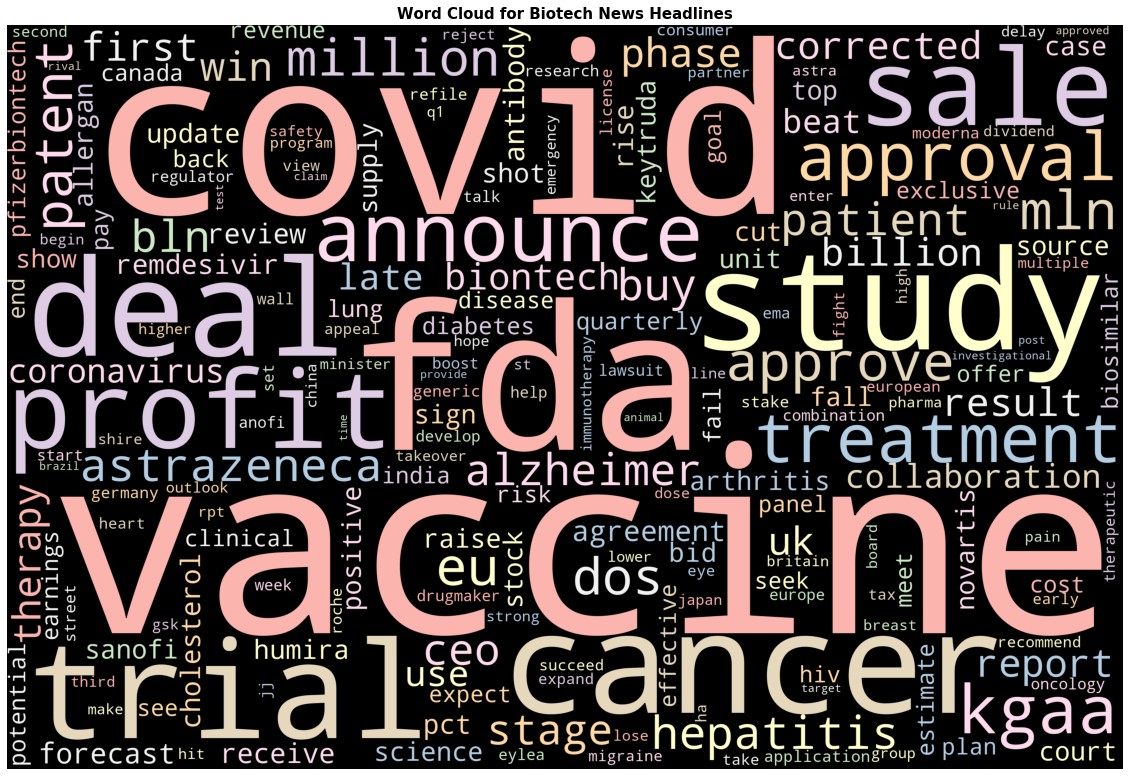

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.title('Word Cloud for Biotech News Headlines', fontweight='bold', fontsize=15)
wordcloud = WordCloud(width = 3000, height = 2000, random_state=42, 
                      background_color='black', colormap='Pastel1', 
                      collocations=False).generate(text)
plt.imshow(wordcloud)
plt.axis("off");

In [18]:
# about a decade's worth of news headlines seem heavily biased on recent covid developments
# we remove recent news to track needle movers for biotech firms (apart from covid)
df = df[df.date < '2020-01-01']
df.reset_index(drop=True, inplace=True)

In [19]:
df.shape

(2945, 8)

In [20]:
text = df[['cleaned']].apply(lambda x: ' '.join(x))[0]

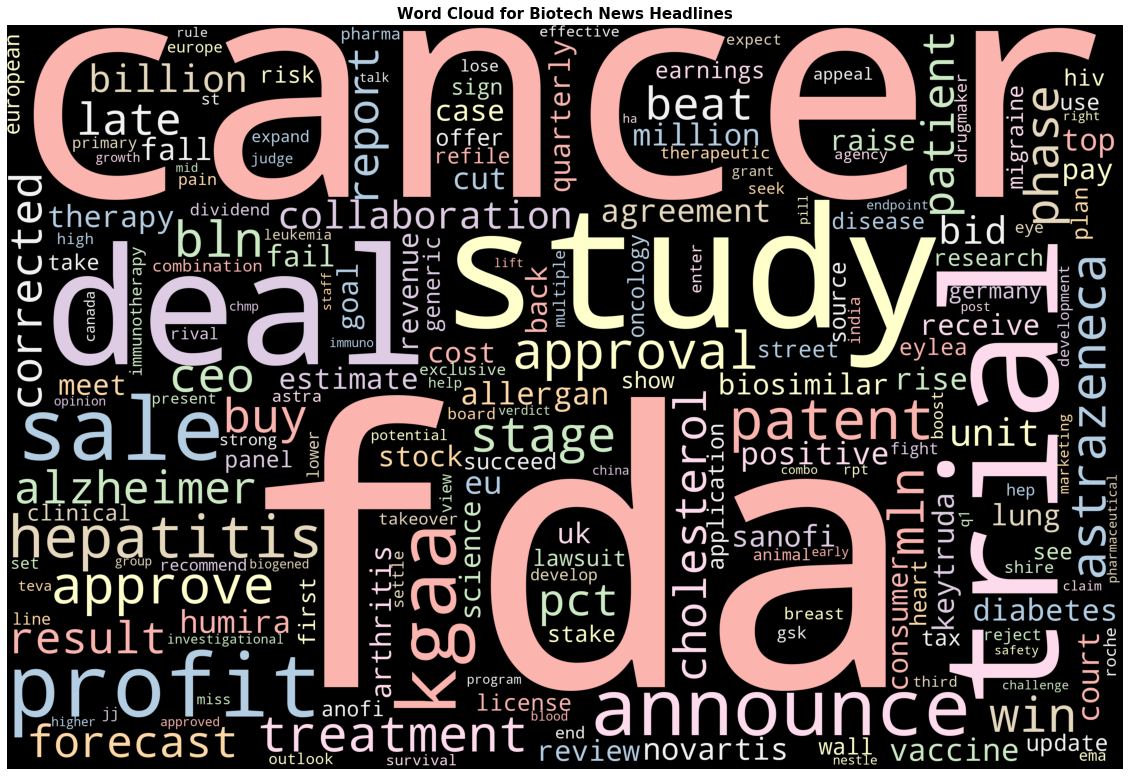

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.title('Word Cloud for Biotech News Headlines', fontweight='bold', fontsize=15)
wordcloud = WordCloud(width = 3000, height = 2000, random_state=42, 
                      background_color='black', colormap='Pastel1', 
                      collocations=False).generate(text)
plt.imshow(wordcloud)
plt.axis("off");

In [22]:
# define function to count words
def word_count(text):
    tokens = re.split('\W+', text) 
    return len(tokens)

In [23]:
# create new columns with word count
df["headline_word"] = df["cleaned"].apply(lambda x: word_count(x))

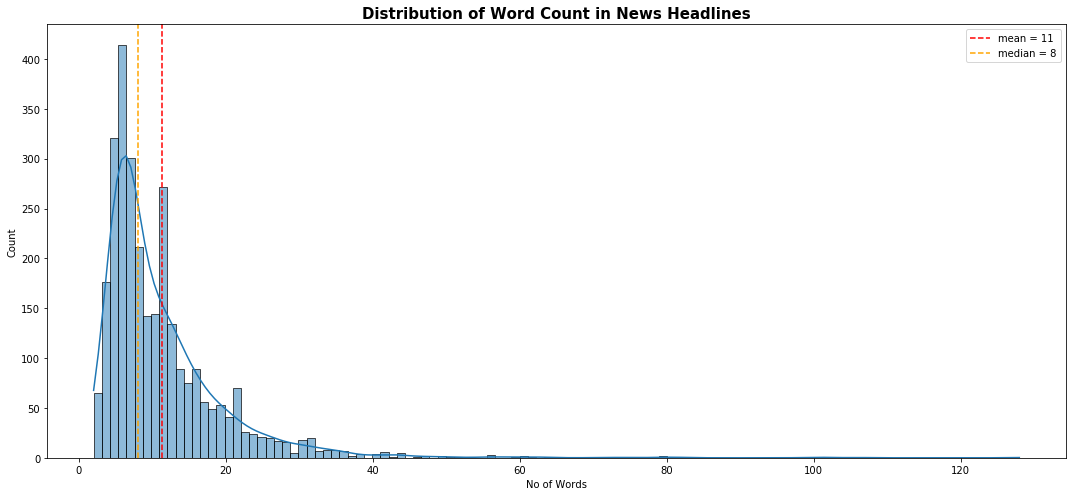

In [24]:
# visualise histogram plots of character word count for news headlines
fig, ax = plt.subplots(figsize=(15, 7))

sns.histplot(data=df, x='headline_word', kde=True)
plt.title('Distribution of Word Count in News Headlines', fontweight='bold', fontsize=15)
plt.axvline(x=df['headline_word'].mean(), label='mean = 11', ls='--', color='r')
plt.axvline(x=df['headline_word'].median(), label='median = 8', ls='--', color='orange')
plt.legend()
plt.xlabel('No of Words')

plt.tight_layout();

## Exploratory Data Analysis & Visualisation

### Descriptive Statistics

In [25]:
# take a look at the descriptive statistics of the numerical features 
df.describe([.5,.75,.9,.99]).round(3)

volume  adjusted  adjusted_abs  news_count  headline_word
count  2.945000e+03  2945.000      2945.000    2945.000       2945.000
mean   1.252303e+07     0.057         1.131       1.846         11.317
std    1.483760e+07     2.022         1.677       1.425          8.899
min    1.213500e+04   -30.360         0.000       1.000          2.000
50%    8.280183e+06     0.007         0.665       1.000          8.000
75%    1.590884e+07     0.702         1.316       2.000         14.000
90%    2.769247e+07     1.654         2.511       3.000         21.000
99%    6.318039e+07     6.308         7.853       7.000         42.560
max    2.844623e+08    26.437        30.360      19.000        128.000

In [26]:
# take a look at the outliers - i.e., P99 of observations with more than 7 news report per day
# majority of the outlying headlines seem to be about pfizer
df[df['news_count'] > 7].sort_values(by='news_count')['text']

259     ['Pfizer may overdose on quick and complex deals', "Pfizer needs a big deal, analysts say; Aller...
311     ['Wave Life Sciences says cash resources with $40 mln in payments from Pfizer will fund expenses...
1276    ['AbbVie boosts cancer drug pipeline with $21 billion Pharmacyclics deal', 'AbbVie CEO may have ...
1078    ['CVS Health says Amgen data may increase eligible patients by millions', 'Wall St. flat as bank...
342     ['Pfizer in $486 mln settlement of Celebrex, Bextra litigation', 'Pfizer says to decide by year ...
163     ['RPT-Fitch Solutions: CDS Sentiment Souring for Pfizer, Improving for AstraZeneca', 'INDIA PRES...
320     ['Pfizer says \\\\"encouraging\\\\" new data from Phase 1\\\\/2 study of Lorlatinib', "Pfizer\\'...
167     ['Senators urge tough U.S. review of Pfizer bid for AstraZeneca', 'Senators urge U.S. anti-trust...
171     ['AstraZeneca says no negotiation with suitor Pfizer allowed under UK rules', 'REFILE-Schroders,...
295     ["Pfizer\\'s Allerga

In [27]:
# remove days with outsized numbers of news report on a particular company 
# this is so that the text data will be not be overly biased towards any specific event or company (e.g. pfizer)
df = df[(df['news_count'] <= 7)]
df.reset_index(drop=True, inplace=True)

In [28]:
df.shape

(2924, 9)

In [29]:
df.describe([.5,.75,.9,.99]).round(3)

volume  adjusted  adjusted_abs  news_count  headline_word
count  2.924000e+03  2924.000      2924.000    2924.000       2924.000
mean   1.218147e+07     0.064         1.123       1.776         10.891
std    1.338584e+07     2.009         1.666       1.136          7.133
min    1.213500e+04   -30.360         0.000       1.000          2.000
50%    8.248408e+06     0.007         0.664       1.000          8.000
75%    1.567897e+07     0.703         1.307       2.000         14.000
90%    2.728284e+07     1.644         2.490       3.000         20.000
99%    6.016675e+07     6.310         7.828       6.000         36.000
max    2.216681e+08    26.437        30.360       7.000         49.000

### Visualise the distribution of possible targets, e.g. absolute changes in stock prices in 1 day

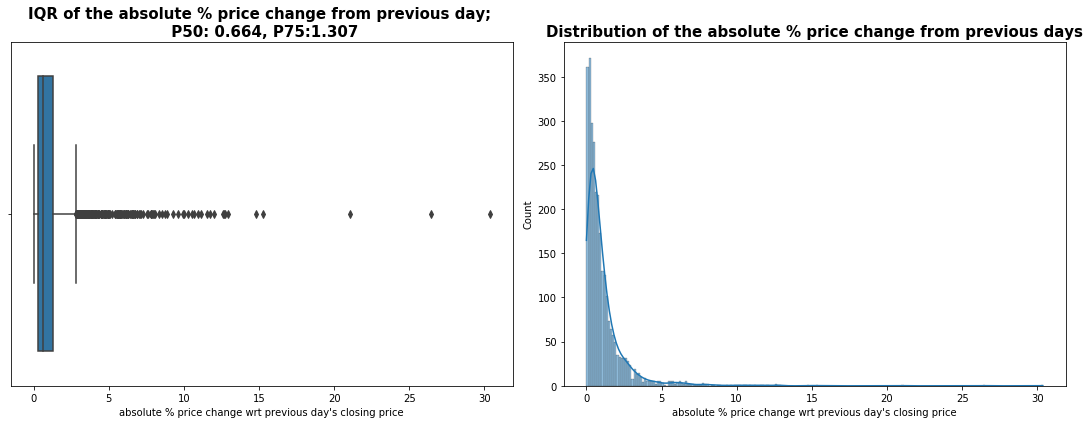

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

sns.boxplot(x=df['adjusted_abs'], ax=ax[0])
ax[0].set_title('IQR of the absolute % price change from previous day; \n P50: 0.664, P75:1.307', 
                  fontsize=15, fontweight="bold")
ax[0].set(xlabel="absolute % price change wrt previous day's closing price")

sns.histplot(x=df['adjusted_abs'], kde=True, ax=ax[1])
ax[1].set_title('Distribution of the absolute % price change from previous days', 
                  fontsize=15, fontweight="bold")
ax[1].set(xlabel="absolute % price change wrt previous day's closing price")

plt.tight_layout();

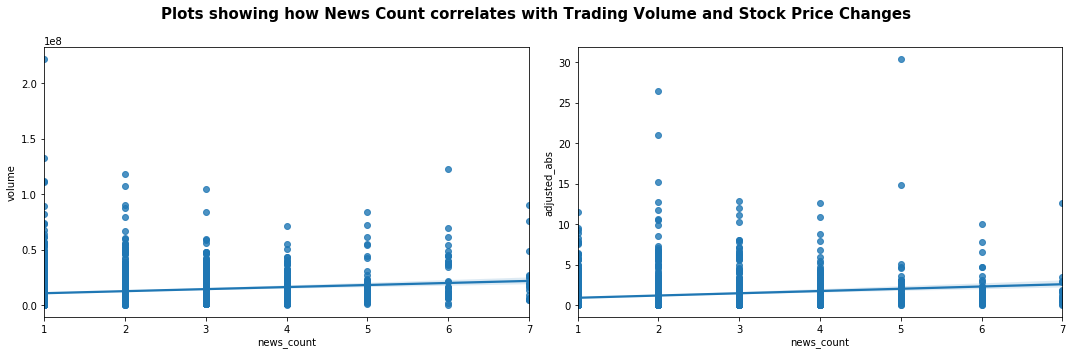

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Plots showing how News Count correlates with Trading Volume and Stock Price Changes", 
             fontsize=15, fontweight="bold")
sns.regplot(x='news_count', y='volume', data=df, ax=ax[0])
sns.regplot(x='news_count', y='adjusted_abs', data=df,  ax=ax[1])

plt.tight_layout();

### Visualise the most common/ important words by count/td-idf vectorizers for news headlines associated with positive and negative share price changes in 1 and 5 days

In [35]:
# create separate dataframes to store headlines associated with positive/negative price changes above median pct change
negative_text_1 = df[(df['adj_direction']=='negative') & (df['adjusted_abs'] > 0.664)]['cleaned']
positive_text_1 = df[(df['adj_direction']=='positive') & (df['adjusted_abs'] > 0.664)]['cleaned']
text_1 = df[(df['adjusted_abs'] > 0.664)]['cleaned']

In [36]:
print(len(negative_text_1)) 
print(len(positive_text_1))
print(len(text_1)) 

711
750
1461


In [37]:
def plot_common_words(text, threshold):
    # find the most common words in the headlines with count vectorization 
    # assuming that they dont appear in more than 70% of all news
    uni_cvec = CountVectorizer(ngram_range=(1, 1), max_features= 30, max_df=threshold)
    uni_cvec_news = uni_cvec.fit_transform(text)

    # get the shape of the sparse matrix
    print(uni_cvec_news.shape)
    
    # convert sparse matrix into a dataframe with feature names
    uni_cvec_news_df = pd.DataFrame(uni_cvec_news.toarray(), columns=uni_cvec.get_feature_names())
    
    # find the most common word pairs headlines with count vectorization
    # assuming that they dont appear in more than 70% of all news
    bi_cvec = CountVectorizer(ngram_range=(2, 2), max_features= 30, max_df=threshold)
    bi_cvec_news = bi_cvec.fit_transform(text)
    
    # get the shape of the sparse matrix
    print(bi_cvec_news.shape)
    
    # convert sparse matrix into a dataframe with feature names
    bi_cvec_news_df = pd.DataFrame(bi_cvec_news.toarray(), columns=bi_cvec.get_feature_names())
    
    # find the most common trigrams in headlines with count vectorization
    # assuming that they dont appear in more than 70% of all news
    tri_cvec = CountVectorizer(ngram_range=(3, 3), max_features= 30,max_df=threshold)
    tri_cvec_news = tri_cvec.fit_transform(positive_text_1)
    
    # get the shape of the sparse matrix
    print(tri_cvec_news.shape)
    
    # convert sparse matrix into a dataframe with feature names
    tri_cvec_news_df = pd.DataFrame(tri_cvec_news.toarray(), columns=tri_cvec.get_feature_names())
    
    # visualise the 30 most common words in headlines
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    
    uni_cvec_news_df.sum().sort_values(ascending=False).head(30).plot(kind='barh', ax=ax[0])
    ax[0].set_title('Most Common Words in News Reported', fontweight='bold', fontsize=15)
    ax[0].invert_yaxis()

    bi_cvec_news_df.sum().sort_values(ascending=False).head(30).plot(kind='barh', ax=ax[1])
    ax[1].set_title('Most Common Words in News Reported', fontweight='bold', fontsize=15)
    ax[1].invert_yaxis()

    tri_cvec_news_df.sum().sort_values(ascending=False).head(30).plot(kind='barh', ax=ax[2])
    ax[2].set_title('Most Common Words in News Reported', fontweight='bold', fontsize=15)
    ax[2].invert_yaxis()

    plt.tight_layout();

In [38]:
def plot_important_words(text, threshold):
    # find the most important words or short phrases in news with tf-idf vectorization
    uni_tvec = TfidfVectorizer(ngram_range=(1, 1), max_features= 30, max_df=threshold)
    uni_tvec_news = uni_tvec.fit_transform(text)
    
    # get the shape of the sparse matrix
    print(uni_tvec_news.shape)
    
    # convert sparse matrix into a dataframe with feature names
    uni_tvec_news_df = pd.DataFrame(uni_tvec_news.toarray(), columns=uni_tvec.get_feature_names())
    
    # find the most important words or short phrases in news with tf-idf vectorization
    bi_tvec = TfidfVectorizer(ngram_range=(2, 2), max_features= 30, max_df=threshold)
    bi_tvec_news = bi_tvec.fit_transform(text)
    
    # get the shape of the sparse matrix
    print(bi_tvec_news.shape)
    
    # convert sparse matrix into a dataframe with feature names
    bi_tvec_news_df = pd.DataFrame(bi_tvec_news.toarray(), columns=bi_tvec.get_feature_names())
    
    # find the most important words or short phrases in news with tf-idf vectorization
    tri_tvec = TfidfVectorizer(ngram_range=(3, 3), max_features= 30, max_df=threshold)
    tri_tvec_news = tri_tvec.fit_transform(text)
    
    # get the shape of the sparse matrix
    print(tri_tvec_news.shape)
    
    # convert sparse matrix into a dataframe with feature names
    tri_tvec_news_df = pd.DataFrame(tri_tvec_news.toarray(), columns=tri_tvec.get_feature_names())
    
    # visualise the 30 most important words in headlines
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    
    uni_tvec_news_df.sum().sort_values(ascending=False).head(30).plot(kind='barh', ax=ax[0])
    ax[0].set_title('Most Important Words in News Reported', fontweight='bold', fontsize=15)
    ax[0].invert_yaxis()
    
    bi_tvec_news_df.sum().sort_values(ascending=False).head(30).plot(kind='barh', ax=ax[1])
    ax[1].set_title('Most Important Words in News Reported', fontweight='bold', fontsize=15)
    ax[1].invert_yaxis()
    
    tri_tvec_news_df.sum().sort_values(ascending=False).head(30).plot(kind='barh', ax=ax[2])
    ax[2].set_title('Most Important Words in News Reported', fontweight='bold', fontsize=15)
    ax[2].invert_yaxis()
    
    plt.tight_layout();

(750, 30)
(750, 30)
(750, 30)
(750, 30)
(750, 30)
(750, 30)


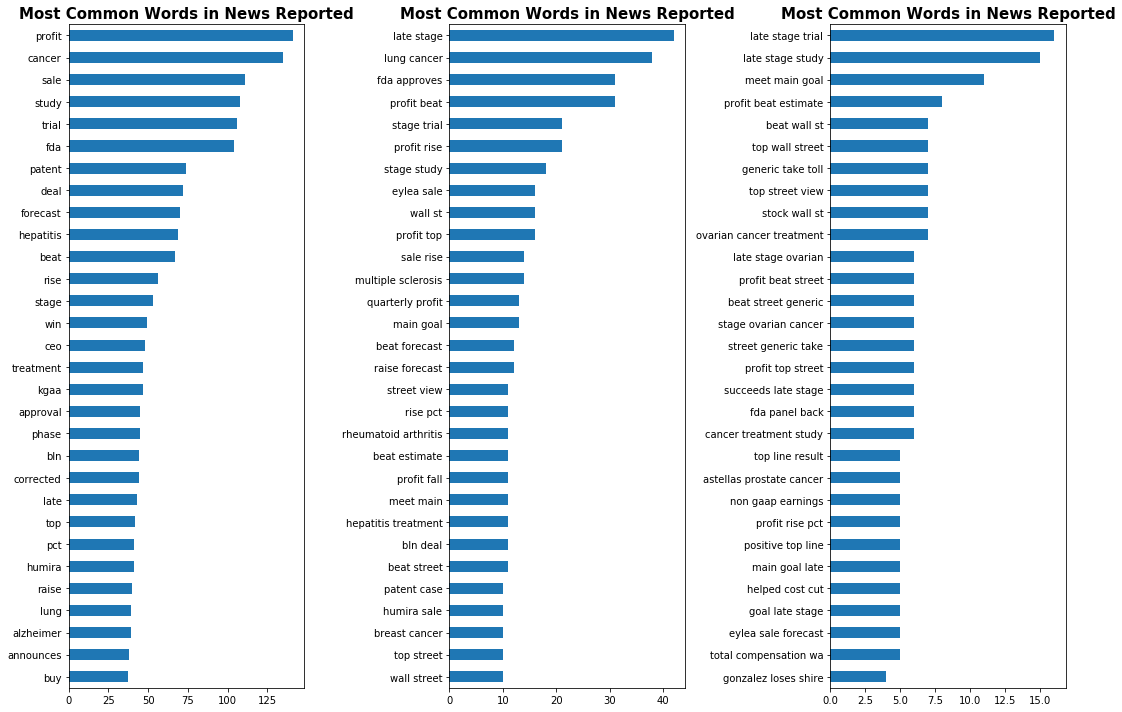

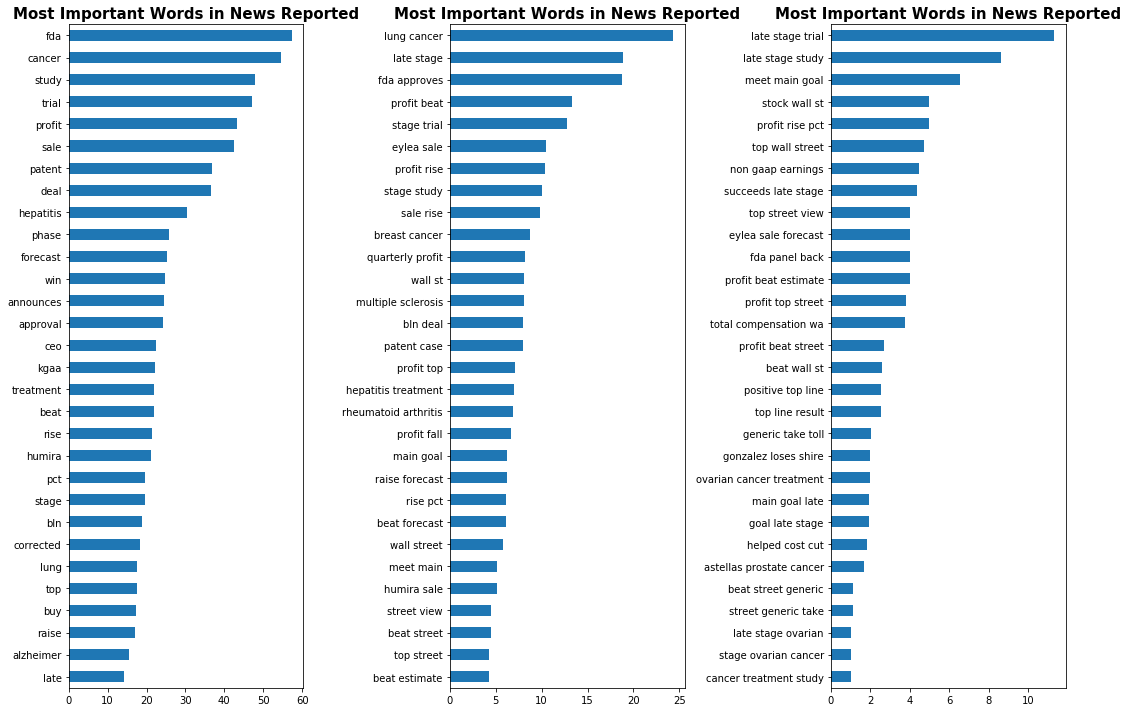

In [39]:
plot_common_words(positive_text_1, 0.5)
plot_important_words(positive_text_1, 0.5)

(711, 30)
(711, 30)
(750, 30)
(711, 30)
(711, 30)
(711, 30)


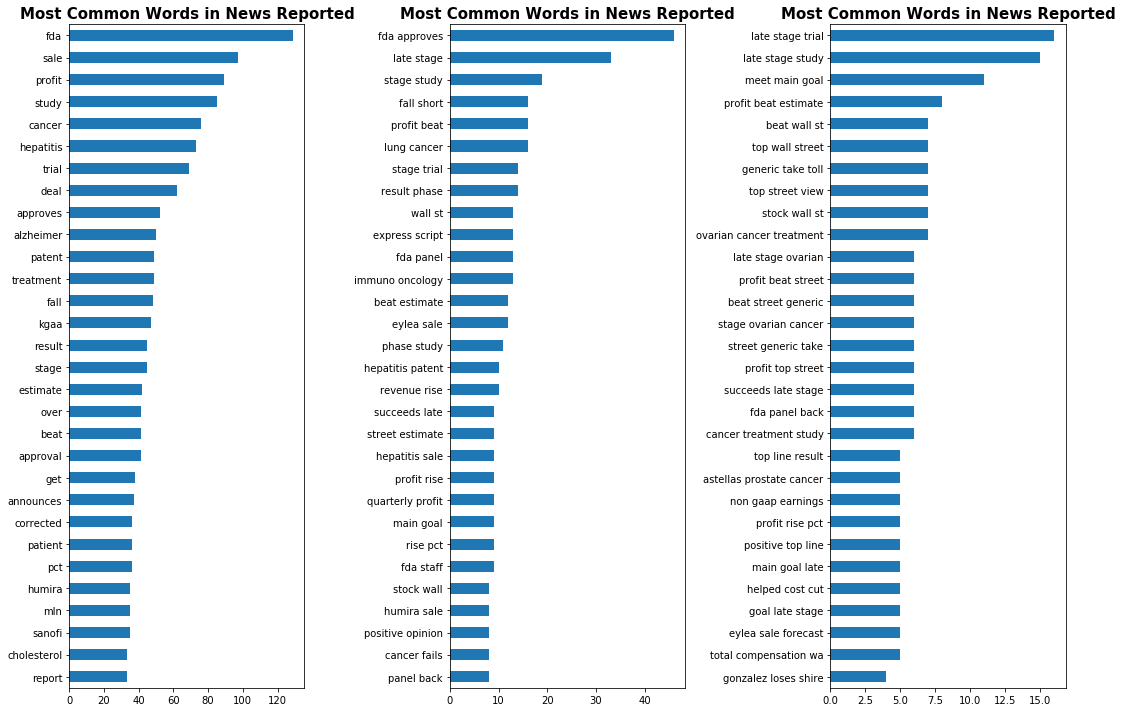

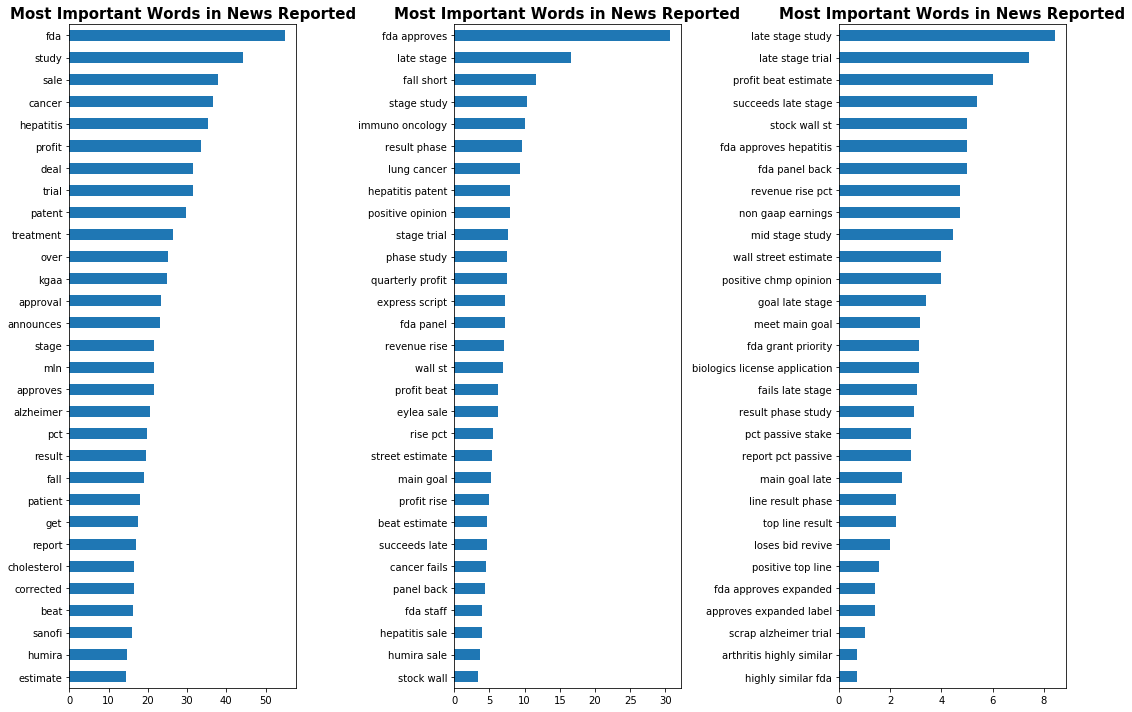

In [40]:
plot_common_words(negative_text_1, 0.5)
plot_important_words(negative_text_1, 0.5)

(1461, 30)
(1461, 30)
(750, 30)
(1461, 30)
(1461, 30)
(1461, 30)


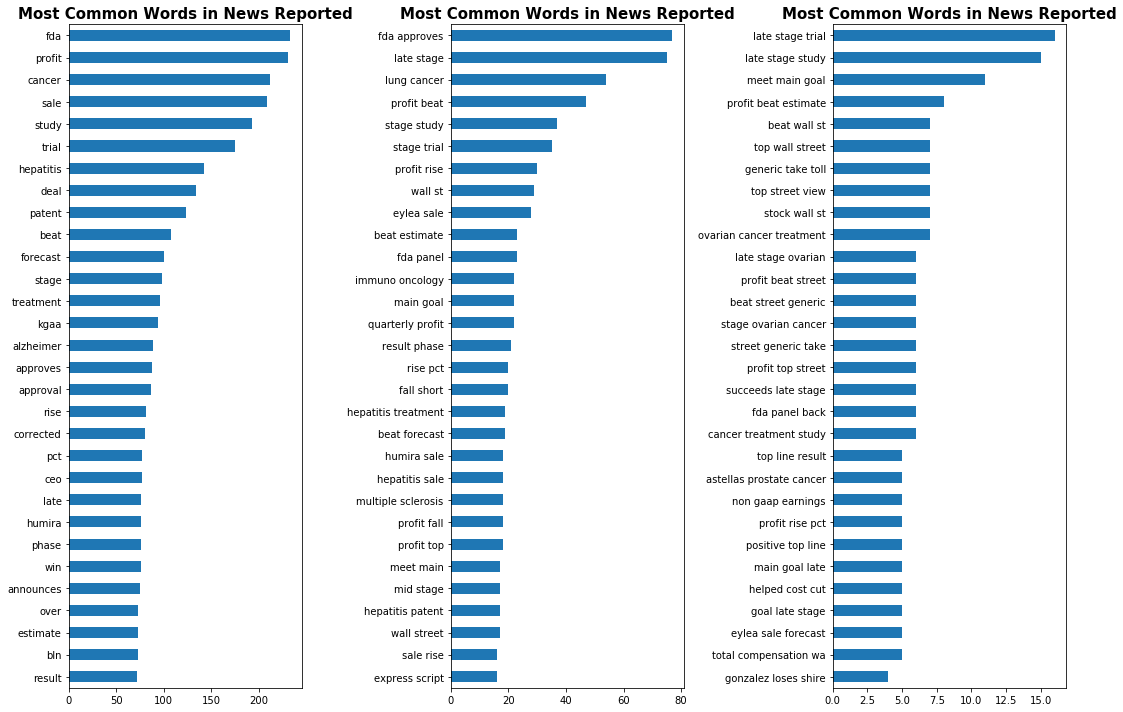

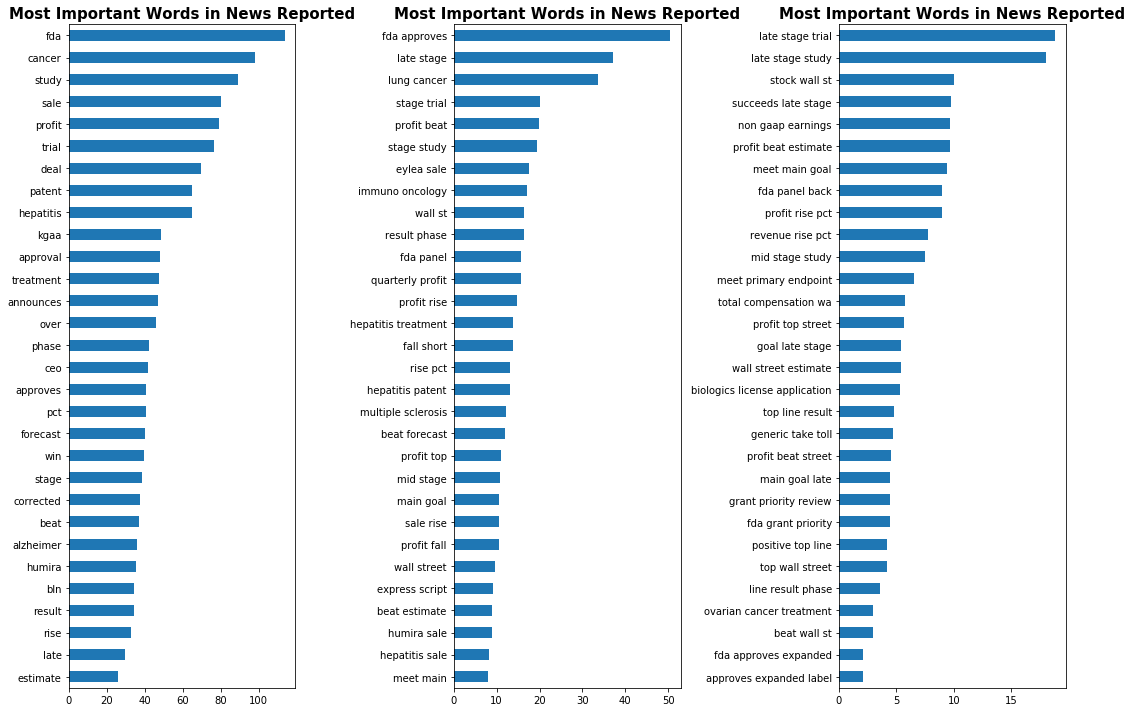

In [41]:
plot_common_words(text_1, 0.5)
plot_important_words(text_1, 0.5)

### Feature Engineering for Text Data - Polarity Score

In [42]:
# define function to obtain vader polarity score (i.e. compound score)
# sentiment scores are give to each comment, ranging from -1 for very negative to +1 for very positive
def vader_polarity(x, text):
    # instantiate the sentiment intensity analyzer
    vader = SentimentIntensityAnalyzer()
    
    # interate through the data to obtain polarity scores using vader
    scores = x.apply(vader.polarity_scores).tolist()
    
    # convert score list into dataframe
    scores_df = pd.DataFrame(scores)
    
    # rename column title
    col_title = str(text + "_polarity")
    scores_df.rename(columns={"compound": col_title},inplace=True)

    return scores_df.iloc[:, -1:]

In [43]:
# append the vader polarity scores to dataframe
df = df.join(vader_polarity(df['cleaned'], "vader"))

In [44]:
# define function to obtain TextBlob polarity score (i.e. compound score)
def sentiment(text):
    sentiment=TextBlob(text)
    return sentiment.sentiment 

In [45]:
# append TextBlob polarity scores to dataframe
df['tb_polarity'] = df['cleaned'].apply(sentiment).apply(lambda x: x[0])

In [46]:
# import created dictionary of positive/negative words related to the Pharma Sector
reader = csv.reader(open('../assets/dict.csv', 'r'))
pharma_dict = dict((rows[0],rows[1]) for rows in reader)

In [47]:
def headlines_score(text):
    # pre-processing the extracted text using ngrams function from the pattern package to create uni/bi/trigram
    word = ngrams(text, n=1)
    bigram = ngrams(text, n=2)
    trigram = ngrams(text, n=3)
    
    uni_dict = {}
    bi_dict = {}
    tri_dict = {}
    positive_score, negative_score = 0, 0
    
    # iterate over the unigrams in the article and check if they exist in the dictionary
    for key, value in pharma_dict.items():
        for x in word:
            if key in x:
                uni_dict[key] = pharma_dict[key] 
                
    # iterate over the bigrams in the article and check if they exist in the dictionary
    for key, value in pharma_dict.items():
        for x in bigram:
            temp = x[0] + ' ' + x[1]
            if temp == key:
                bi_dict[key] = pharma_dict[key]
                
    # iterate over the trigrams in the article and check if they exist in the dictionary
    for key, value in pharma_dict.items():
        for x in trigram:
            temp = x[0] + ' ' + x[1] + ' ' + x[2]
            if temp == key:
                tri_dict[key] = pharma_dict[key]

    # append postive and negative tag in the list                      
    positive_list = [] ; negative_list = [];
       
    for key, value in uni_dict.items():
        if value == 'positive':
            positive_list.append(key)
        if value == 'negative':
            negative_list.append(key)
            
    for key, value in bi_dict.items():
        if value == 'positive':
            positive_list.append(key)
        if value == 'negative':
            negative_list.append(key)
                                     
    # compute the positive score, the negative score for each news articles
    positive_score = len(positive_list) ; negative_score = len(negative_list);
   
    # calculating overall score
    overall_score = positive_score - negative_score
    return overall_score

In [48]:
# append dictionary scores to dataframe
df['dict_score'] = df['cleaned'].apply(headlines_score)

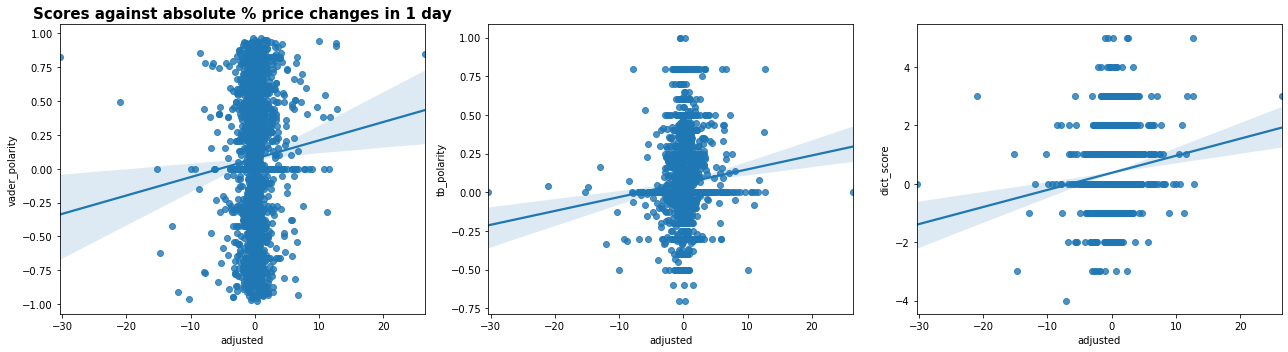

In [52]:
# plot how polarity scores changes with stock price changes 
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].set_title('Scores against absolute % price changes in 1 day', fontweight='bold', fontsize=15)
sns.regplot(data=df, x='adjusted', y='vader_polarity', ax=ax[0])

sns.regplot(data=df, x='adjusted', y='tb_polarity', ax=ax[1])

sns.regplot(data=df, x='adjusted', y='dict_score', ax=ax[2])

fig.tight_layout();

### Examine Trends overtime

In [54]:
# create a copy of the original data frame and create new feature - Year_Month
df["date"] = pd.to_datetime(df['date'])
df['Year_Month'] = df['date'].dt.strftime('%Y %m')

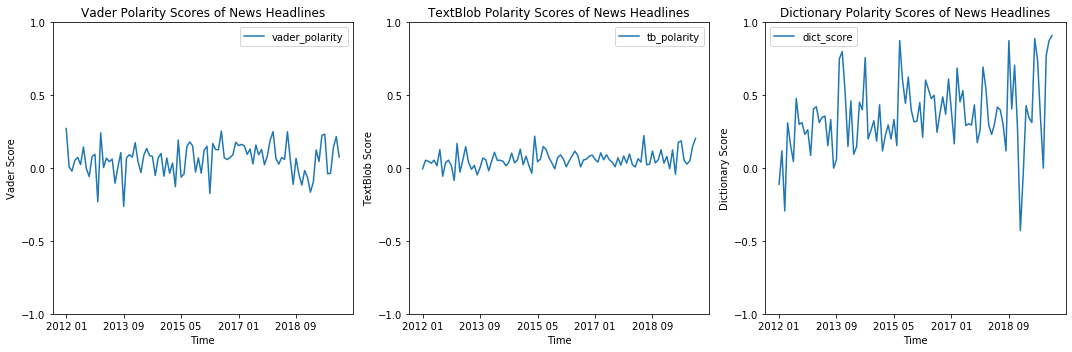

In [60]:
# create pivot table to aggregate mean polarity scores by each month of the year
vader_table = pd.pivot_table(df, values='vader_polarity', index='Year_Month', aggfunc='mean')
tb_table = pd.pivot_table(df, values='tb_polarity', index='Year_Month', aggfunc='mean')
dict_table = pd.pivot_table(df, values='dict_score', index='Year_Month', aggfunc='mean')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# plot graph to show how mean polarity scores of headlines tend to change 
vader_table.plot(kind='line',figsize=(15,5),
                 title='Vader Polarity Scores of News Headlines',
                 yticks=(np.linspace(-1,1,5)), ylabel="Vader Score", xlabel="Time", ax=ax[0])

tb_table.plot(kind='line',figsize=(15,5),
              title='TextBlob Polarity Scores of News Headlines',
              yticks=(np.linspace(-1,1,5)), ylabel="TextBlob Score", xlabel="Time", ax=ax[1])

dict_table.plot(kind='line',figsize=(15,5),
                title='Dictionary Polarity Scores of News Headlines',
                yticks=(np.linspace(-1,1,5)), ylabel="Dictionary Score", xlabel="Time", ax=ax[2])

fig.tight_layout();

In [61]:
df.columns

Index(['volume', 'date', 'adjusted', 'adjusted_abs', 'text', 'news_count',
       'adj_direction', 'cleaned', 'headline_word', 'vader_polarity',
       'tb_polarity', 'dict_score', 'Year_Month'],
      dtype='object')

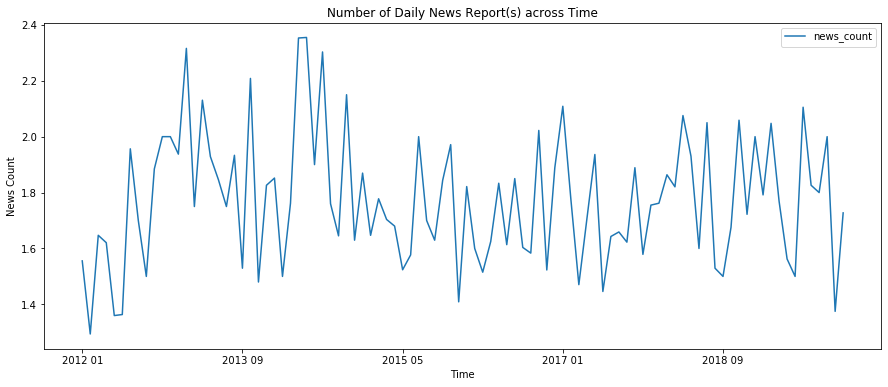

In [62]:
# create pivot table to aggregate mean polarity scores by each month of the year
news_count_table = pd.pivot_table(df, values='news_count', index='Year_Month', aggfunc='mean')

# plot graph to show how mean number of news report by month tend to change overtime 
news_count_table.plot(kind='line',figsize=(15,6),
              title='Number of Daily News Report(s) across Time', ylabel="News Count", xlabel="Time");

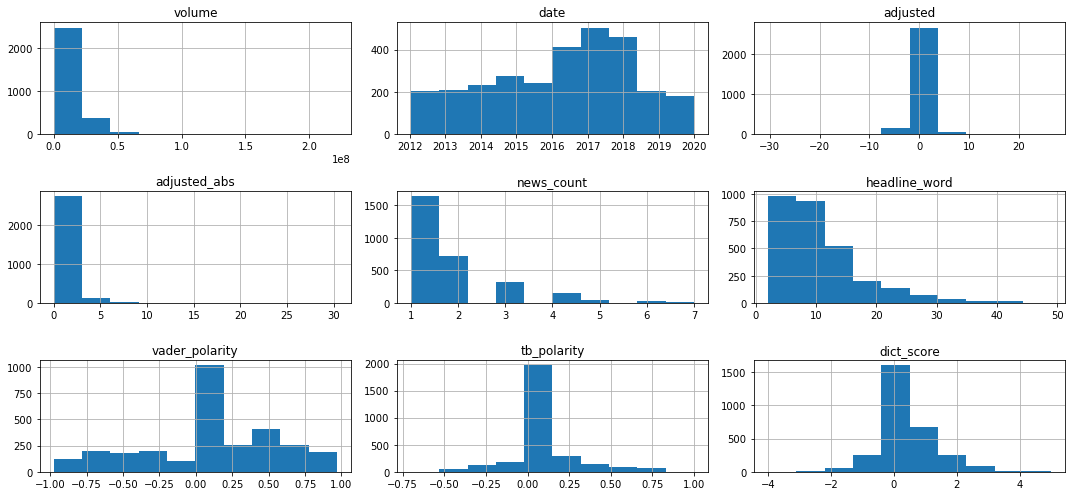

In [63]:
### Plot histograms to look at distributions of the numerical features
# the distributions are largely right skewed with a long tail (i.e. outliers)
df.hist(figsize=(15,7))
plt.tight_layout();

### Heatmap to look at correlation of existing features

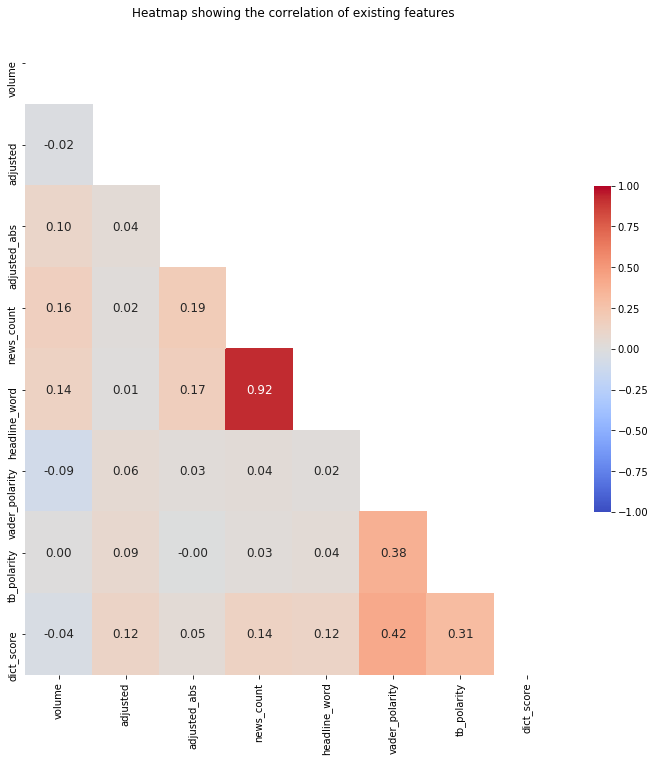

In [64]:
# plot a heatmap to look at the correlation matrix of existing variables
# getting the Upper Triangle of the co-relation matrix
matrix = np.triu(df.corr())

# using the upper triangle matrix as mask 
plt.figure(figsize=(12,12))
plt.title("Heatmap showing the correlation of existing features")
sns.heatmap(df.corr(), annot=True, mask= matrix, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1, cbar_kws={"shrink": .5});

In [65]:
df.adjusted_abs.describe()

count    2924.000000
mean        1.123209
std         1.666237
min         0.000117
25%         0.284782
50%         0.663807
75%         1.306779
max        30.359943
Name: adjusted_abs, dtype: float64

### Define and create `Target` feature

In [66]:
# create function to create binary target feature, i.e. whether absolute change in adjusted stock prices is > P75
def significant_change(price):
    if abs(price) >= 1.31:
        return 1
    else:
        return 0

In [67]:
df['target_var'] = df['adjusted_abs'].apply(significant_change)

In [69]:
df.head()

volume       date  adjusted  adjusted_abs  \
0   29067200 2012-01-13 -0.164794      0.164794   
1  132872800 2012-01-27 -0.647985      0.647985   
2   55526800 2012-01-31 -0.796045      0.796045   
3   37375900 2012-02-07  0.224445      0.224445   
4   25262900 2012-02-14  0.266436      0.266436   

                                                                                                  text  \
0                                                ['Nestle declines comment on Pfizer unit bid report']   
1                                              ["US FDA approves Pfizer\\'s Inlyta for kidney cancer"]   
2    ['Generics take toll on Pfizer, Lilly profits', 'Pfizer trims 2012 view, citing stronger dollar']   
3  ["India\\'s Pfizer to spin-off animal healthcare business", "Dealtalk: Nestle in lead to scoop u...   
4  ["Pfizer says its drug is best hope for Alzheimer\\'s", "Pfizer says its drug is best hope vs. A...   

   news_count adj_direction  \
0           1      negative   
1           1      negative   
2           2      negative   
3           3      positive   
4           2      positive   

                                                                                               cleaned  \
0                                                               nestle decline comment unit bid report   
1                                                                    fda approves inlyta kidney cancer   
2                                            generic take toll profit trim view citing stronger dollar   
3  india spin off animal dealtalk nestle lead scoop up baby formula unit dealtalk nestle lead scoop...   
4                                                              best hope alzheimer best hope alzheimer   

   headline_word  vader_polarity  tb_polarity  dict_score Year_Month  \
0              6          0.0000          0.0          -1    2012 01   
1              5         -0.4019          0.0           2    2012 01   
2              9          0.6705          0.0          -1    2012 01   
3             20          0.2960          0.0           0    2012 02   
4              6          0.9349          1.0           0    2012 02   

   target_var  
0           0  
1           0  
2           0  
3           0  
4           0

In [70]:
# Create dataframe to temporarily combine titles, labels and counts
# To look at most common words

# Split into class 1 and 0
price_shock = df[df['target_var']==1]
price_constant = df[df['target_var']==0]

# Do a simple preprocesing split the words using .split
words_shock = [post.split() for post in price_shock['cleaned']]
words_constant = [post.split() for post in price_constant['cleaned']]

# Flatten list, so that all words across the posts are in one list
all_words_shock = list(itertools.chain(*words_shock))
all_words_constant = list(itertools.chain(*words_constant))

# To get the count of how many times each word appears in the train set
# Use built-in Python library 'collections'
shock = collections.Counter(all_words_shock)
constant = collections.Counter(all_words_constant)

# The 'collection.Counter' object has 'most_common' that will return the most commonly used words and the number of times that they are used.
# Show most 150 most common words for each class
print("Most Label=1 common 150 words:\n")
print(shock.most_common(150))
print('      ')
print("Most Label=0 common 150 words:\n")
print(constant.most_common(150))

Most Label=1 common 150 words:

[('sale', 142), ('profit', 133), ('fda', 127), ('cancer', 102), ('trial', 91), ('study', 83), ('forecast', 77), ('patent', 75), ('hepatitis', 69), ('rise', 67), ('deal', 67), ('alzheimer', 66), ('beat', 62), ('pct', 55), ('win', 54), ('revenue', 53), ('fall', 51), ('treatment', 49), ('eylea', 49), ('humira', 48), ('stock', 47), ('ceo', 46), ('result', 45), ('stage', 45), ('approves', 44), ('over', 43), ('estimate', 42), ('earnings', 42), ('quarterly', 41), ('bln', 40), ('approval', 39), ('corrected', 39), ('phase', 39), ('top', 38), ('report', 36), ('get', 35), ('cut', 34), ('late', 34), ('mln', 33), ('cholesterol', 33), ('shire', 33), ('up', 32), ('allergan', 32), ('raise', 31), ('wall', 31), ('collaboration', 30), ('hiv', 30), ('cost', 29), ('case', 29), ('announces', 29), ('buy', 29), ('sanofi', 29), ('generic', 28), ('positive', 28), ('street', 27), ('vaccine', 27), ('plan', 27), ('novartis', 27), ('billion', 27), ('lung', 27), ('review', 27), ('diab

In [71]:
# top 150 words convert to dataframe to use later
shock_df = pd.DataFrame(shock.most_common(150),
                             columns=['words', 'count'])
constant_df = pd.DataFrame(constant.most_common(150),
                             columns=['words', 'count'])

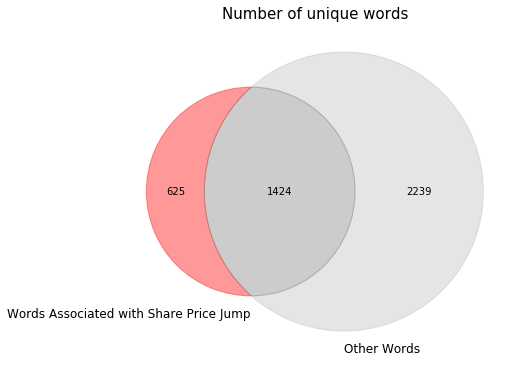

In [73]:
# plot venn diagram on number of unique words for each class
# set figure size
fig, ax = plt.subplots(figsize = (7,10))
# set title
ax.set_title('Number of unique words', fontsize=15)
sets = [set(all_words_shock),set(all_words_constant)]
# plot venn diafram
v=venn2(sets, set_labels = ('Words Associated with Share Price Jump', 'Other Words'),ax=ax)

# add color and design
v.get_patch_by_id('10').set_color('red')
v.get_patch_by_id('10').set_alpha(0.4)
v.get_patch_by_id('01').set_color('grey')
v.get_patch_by_id('01').set_alpha(0.2)
v.get_patch_by_id('11').set_color('grey')
v.get_patch_by_id('11').set_alpha(0.4)

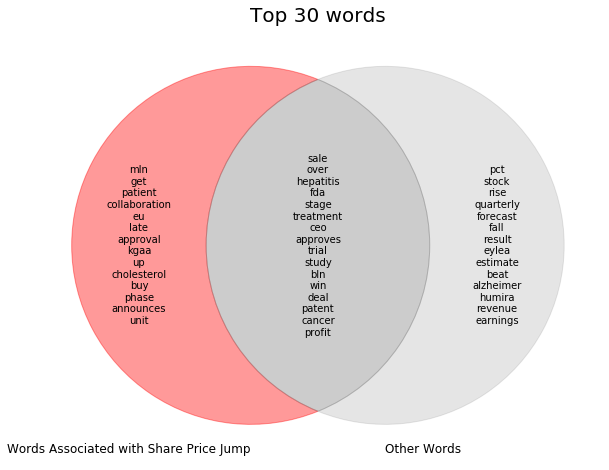

In [75]:
# Display venn diagram top 30 words for training preprocessing data for each class
# select top 30 words for each label
A = set(shock_df.loc[0:29,'words'])
B = set(constant_df.loc[0:29,'words'])

# set figure size
fig, ax = plt.subplots(figsize = (19,8))
# set title
ax.set_title('Top 30 words', fontsize=20)
# plot venn diafram
v = venn2([A,B], ('Words Associated with Share Price Jump', 'Other Words'),ax=ax)
v.get_label_by_id('10').set_text('\n'.join(B-A))
v.get_label_by_id('11').set_text('\n'.join(A&B))
v.get_label_by_id('01').set_text('\n'.join(A-B))

# add color
v.get_patch_by_id('10').set_color('red')
v.get_patch_by_id('10').set_alpha(0.4)
v.get_patch_by_id('01').set_color('grey')
v.get_patch_by_id('01').set_alpha(0.2)
v.get_patch_by_id('11').set_color('grey')
v.get_patch_by_id('11').set_alpha(0.4);

### Explore correlation of common/ important words with constructed target

In [76]:
# instantiate a CountVectorizer
cvec = CountVectorizer(ngram_range=(1,1), max_features= 30, max_df=0.5)

# fit the vectorizer on our corpus; X_cvec stores the vectorised data
X_cvec = cvec.fit_transform(df["cleaned"])

# returns the number of rows and columns of X_cvec
print(X_cvec.shape) 

# returns the unique words across alll text messages
print(cvec.get_feature_names())

# Due to the nature of sparse matrices where only non-zero elements are stored, 
# we expand it out to a collection of arrays and store it in a data frame
X_cvec_df = pd.DataFrame(X_cvec.toarray())
X_cvec_df.columns = cvec.get_feature_names()
X_cvec_df.head()

# merge vectorized dataset with original data fields
count_df = pd.concat([df[['target_var']], X_cvec_df], axis=1)

(2924, 30)
['announces', 'approval', 'approves', 'beat', 'bln', 'buy', 'cancer', 'ceo', 'cholesterol', 'deal', 'fda', 'forecast', 'hepatitis', 'kgaa', 'late', 'mln', 'over', 'patent', 'patient', 'pct', 'phase', 'profit', 'result', 'sale', 'stage', 'study', 'treatment', 'trial', 'up', 'win']


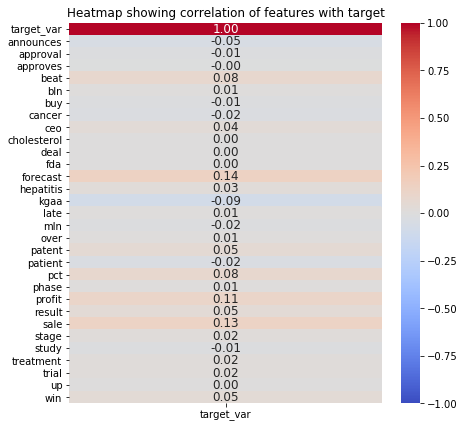

In [77]:
plt.figure(figsize=(7,7))
plt.title("Heatmap showing correlation of features with target")
sns.heatmap(count_df.corr()[["target_var"]], annot=True, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

In [78]:
# instantiate a CountVectorizer
cvec = CountVectorizer(ngram_range=(2,2), max_features= 30, max_df=0.5)

# fit the vectorizer on our corpus; X_cvec stores the vectorised data
X_cvec = cvec.fit_transform(df["cleaned"])

# returns the number of rows and columns of X_cvec
print(X_cvec.shape) 

# returns the unique words across alll text messages
print(cvec.get_feature_names())

# Due to the nature of sparse matrices where only non-zero elements are stored, 
# we expand it out to a collection of arrays and store it in a data frame
X_cvec_df = pd.DataFrame(X_cvec.toarray())
X_cvec_df.columns = cvec.get_feature_names()
X_cvec_df.head()

# merge vectorized dataset with original data fields
count_df = pd.concat([df[['target_var']], X_cvec_df], axis=1)

(2924, 30)
['beat estimate', 'breast cancer', 'cancer trial', 'clinical trial', 'eylea sale', 'fda approval', 'fda approves', 'fda panel', 'fda staff', 'hepatitis patent', 'immuno oncology', 'late stage', 'license agreement', 'lung cancer', 'main goal', 'multiple sclerosis', 'pay million', 'pay mln', 'phase study', 'primary endpoint', 'priority review', 'profit beat', 'profit rise', 'profit top', 'quarterly profit', 'result phase', 'stage study', 'stage trial', 'succeeds late', 'wall st']


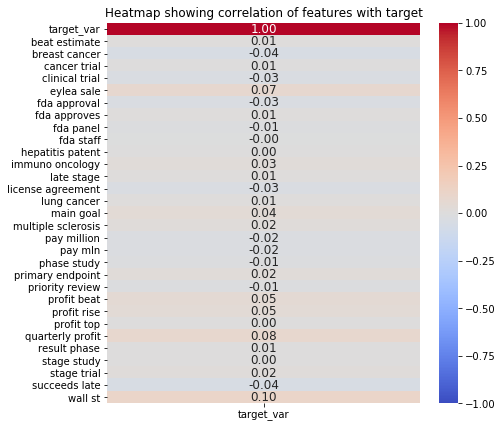

In [79]:
plt.figure(figsize=(7,7))
plt.title("Heatmap showing correlation of features with target")
sns.heatmap(count_df.corr()[["target_var"]], annot=True, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

In [80]:
# instantiate a CountVectorizer
cvec = CountVectorizer(ngram_range=(3,3), max_features= 30, max_df=0.5)

# fit the vectorizer on our corpus; X_cvec stores the vectorised data
X_cvec = cvec.fit_transform(df["cleaned"])

# returns the number of rows and columns of X_cvec
print(X_cvec.shape) 

# returns the unique words across alll text messages
print(cvec.get_feature_names())

# Due to the nature of sparse matrices where only non-zero elements are stored, 
# we expand it out to a collection of arrays and store it in a data frame
X_cvec_df = pd.DataFrame(X_cvec.toarray())
X_cvec_df.columns = cvec.get_feature_names()
X_cvec_df.head()

# merge vectorized dataset with original data fields
count_df = pd.concat([df[['target_var']], X_cvec_df], axis=1)

(2924, 30)
['announces positive top', 'biologics license application', 'breakthrough therapy designation', 'compensation wa mln', 'fails late stage', 'fda grant priority', 'fda panel back', 'goal late stage', 'grant priority review', 'late stage study', 'late stage trial', 'line result phase', 'main goal late', 'meet main goal', 'meet primary endpoint', 'mid stage study', 'non gaap earnings', 'positive chmp opinion', 'positive top line', 'profit beat estimate', 'profit rise pct', 'profit top street', 'result phase study', 'set quarterly dividend', 'stock wall st', 'succeeds late stage', 'supplemental biologics license', 'top line result', 'top street view', 'total compensation wa']


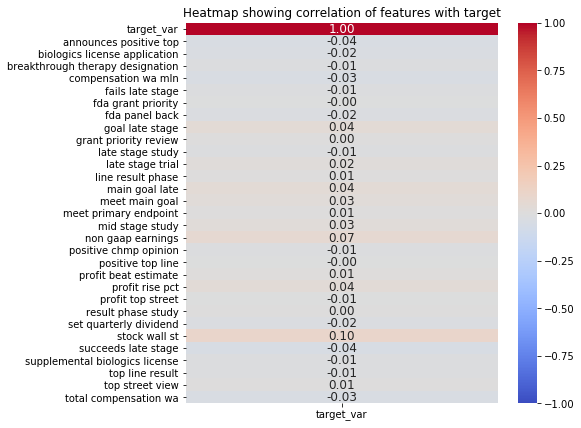

In [81]:
plt.figure(figsize=(7,7))
plt.title("Heatmap showing correlation of features with target")
sns.heatmap(count_df.corr()[["target_var"]], annot=True, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

In [82]:
# instantiate a TF-IDFVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1,1), max_features=30, max_df=0.5)
X_tfidf = tfidf_vect.fit_transform(df['cleaned'])

print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

# we expand sparse matrix out to a collection of arrays and store it in a data frame
tfidf_df = pd.DataFrame(X_tfidf.toarray())
tfidf_df.columns = tfidf_vect.get_feature_names()
tfidf_df.head()

# merge vectorized dataset with original data fields
tfidf_df = pd.concat([df[['target_var']], tfidf_df], axis=1)
tfidf_df.head()

(2924, 30)
['announces', 'approval', 'approves', 'beat', 'bln', 'buy', 'cancer', 'ceo', 'cholesterol', 'deal', 'fda', 'forecast', 'hepatitis', 'kgaa', 'late', 'mln', 'over', 'patent', 'patient', 'pct', 'phase', 'profit', 'result', 'sale', 'stage', 'study', 'treatment', 'trial', 'up', 'win']


target_var  announces  approval  approves  beat  bln  buy    cancer  ceo  \
0           0        0.0       0.0   0.00000   0.0  0.0  0.0  0.000000  0.0   
1           0        0.0       0.0   0.67805   0.0  0.0  0.0  0.526002  0.0   
2           0        0.0       0.0   0.00000   0.0  0.0  0.0  0.000000  0.0   
3           0        0.0       0.0   0.00000   0.0  0.0  0.0  0.000000  0.0   
4           0        0.0       0.0   0.00000   0.0  0.0  0.0  0.000000  0.0   

   cholesterol  deal       fda  forecast  hepatitis  kgaa  late  mln  over  \
0          0.0   0.0  0.000000       0.0        0.0   0.0   0.0  0.0   0.0   
1          0.0   0.0  0.513391       0.0        0.0   0.0   0.0  0.0   0.0   
2          0.0   0.0  0.000000       0.0        0.0   0.0   0.0  0.0   0.0   
3          0.0   0.0  0.000000       0.0        0.0   0.0   0.0  0.0   0.0   
4          0.0   0.0  0.000000       0.0        0.0   0.0   0.0  0.0   0.0   

   patent  patient  pct  phase  profit  result  sale  stage  study  treatment  \
0     0.0      0.0  0.0    0.0     0.0     0.0   0.0    0.0    0.0        0.0   
1     0.0      0.0  0.0    0.0     0.0     0.0   0.0    0.0    0.0        0.0   
2     0.0      0.0  0.0    0.0     1.0     0.0   0.0    0.0    0.0        0.0   
3     0.0      0.0  0.0    0.0     0.0     0.0   0.0    0.0    0.0        0.0   
4     0.0      0.0  0.0    0.0     0.0     0.0   0.0    0.0    0.0        0.0   

   trial   up  win  
0    0.0  0.0  0.0  
1    0.0  0.0  0.0  
2    0.0  0.0  0.0  
3    0.0  1.0  0.0  
4    0.0  0.0  0.0

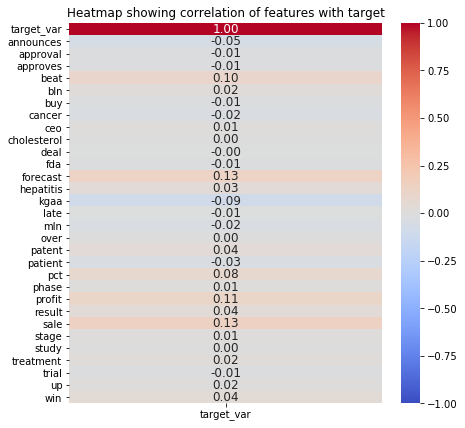

In [83]:
plt.figure(figsize=(7,7))
plt.title("Heatmap showing correlation of features with target")
sns.heatmap(tfidf_df.corr()[["target_var"]], annot=True, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

In [84]:
# instantiate a TF-IDFVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(2,2), max_features=30, max_df=0.5)
X_tfidf = tfidf_vect.fit_transform(df['cleaned'])

print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

# we expand sparse matrix out to a collection of arrays and store it in a data frame
tfidf_df = pd.DataFrame(X_tfidf.toarray())
tfidf_df.columns = tfidf_vect.get_feature_names()
tfidf_df.head()

# merge vectorized dataset with original data fields
tfidf_df = pd.concat([df[['target_var']], tfidf_df], axis=1)

(2924, 30)
['beat estimate', 'breast cancer', 'cancer trial', 'clinical trial', 'eylea sale', 'fda approval', 'fda approves', 'fda panel', 'fda staff', 'hepatitis patent', 'immuno oncology', 'late stage', 'license agreement', 'lung cancer', 'main goal', 'multiple sclerosis', 'pay million', 'pay mln', 'phase study', 'primary endpoint', 'priority review', 'profit beat', 'profit rise', 'profit top', 'quarterly profit', 'result phase', 'stage study', 'stage trial', 'succeeds late', 'wall st']


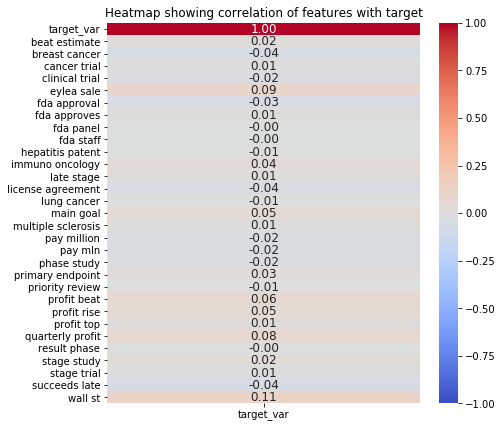

In [85]:
plt.figure(figsize=(7,7))
plt.title("Heatmap showing correlation of features with target")
sns.heatmap(tfidf_df.corr()[["target_var"]], annot=True, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

In [86]:
# instantiate a TF-IDFVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(3,3), max_features=30, max_df=0.5)
X_tfidf = tfidf_vect.fit_transform(df['cleaned'])

print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

# we expand sparse matrix out to a collection of arrays and store it in a data frame
tfidf_df = pd.DataFrame(X_tfidf.toarray())
tfidf_df.columns = tfidf_vect.get_feature_names()
tfidf_df.head()

# merge vectorized dataset with original data fields
tfidf_df = pd.concat([df[['target_var']], tfidf_df], axis=1)

(2924, 30)
['announces positive top', 'biologics license application', 'breakthrough therapy designation', 'compensation wa mln', 'fails late stage', 'fda grant priority', 'fda panel back', 'goal late stage', 'grant priority review', 'late stage study', 'late stage trial', 'line result phase', 'main goal late', 'meet main goal', 'meet primary endpoint', 'mid stage study', 'non gaap earnings', 'positive chmp opinion', 'positive top line', 'profit beat estimate', 'profit rise pct', 'profit top street', 'result phase study', 'set quarterly dividend', 'stock wall st', 'succeeds late stage', 'supplemental biologics license', 'top line result', 'top street view', 'total compensation wa']


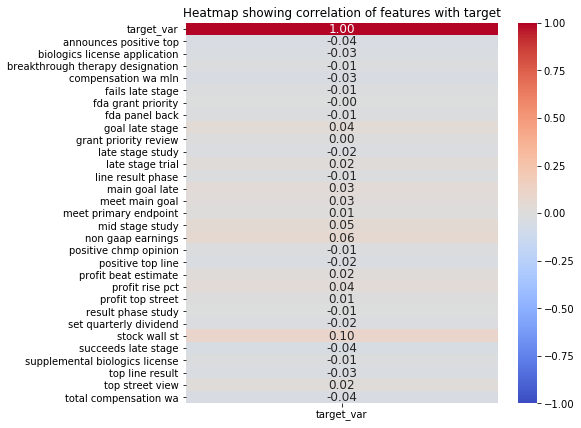

In [87]:
plt.figure(figsize=(7,7))
plt.title("Heatmap showing correlation of features with target")
sns.heatmap(tfidf_df.corr()[["target_var"]], annot=True, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

### Export Clean & Vectorized Data

In [88]:
def CountVect(df, n_gram, n_features):
    
    cvec = CountVectorizer(ngram_range=(n_gram,n_gram), max_features= n_features, min_df=2, max_df=0.9)
    X_cvec = cvec.fit_transform(df["cleaned"])
    
    print(X_cvec.shape) 
    print(cvec.get_feature_names())
    
    X_cvec_df = pd.DataFrame(X_cvec.toarray())
    X_cvec_df.columns = cvec.get_feature_names()
    
    count_df = pd.concat([df[['target_var']], X_cvec_df], axis=1)
    
    return count_df

In [89]:
def TfIdfVect(df, n_gram, n_features):
    
    tfidf_vect = TfidfVectorizer(ngram_range=(n_gram,n_gram), max_features= n_features, min_df=2, max_df=0.9)
    X_tfidf = tfidf_vect.fit_transform(df["cleaned"])
    
    print(X_tfidf.shape) 
    print(tfidf_vect.get_feature_names())
    
    tfidf_df = pd.DataFrame(X_tfidf.toarray())
    tfidf_df.columns = tfidf_vect.get_feature_names()
    
    tfidf_df = pd.concat([df[['target_var']], tfidf_df], axis=1)
    
    return tfidf_df

In [90]:
uni_count_df = CountVect(df, 1, 1_000)
bi_count_df = CountVect(df, 2, 1_000)
tri_count_df = CountVect(df, 3, 1_000)
uni_tfidf_df = TfIdfVect(df, 1, 1_000)
bi_tfidf_df = TfIdfVect(df, 2, 1_000)
tri_tfidf_df = TfIdfVect(df, 3, 1_000)

(2924, 1000)
['1b', '1st', '2nd', '3rd', '4th', 'abbott', 'ablynx', 'above', 'abp', 'accelerated', 'acceptance', 'accepted', 'accepts', 'access', 'acquire', 'acquires', 'acquisition', 'action', 'acute', 'add', 'additional', 'adj', 'adjusted', 'adocia', 'adolescent', 'adopts', 'aducanumab', 'adult', 'advance', 'advanced', 'advisory', 'africa', 'agency', 'agent', 'agree', 'agreement', 'agrees', 'ahead', 'aid', 'aim', 'aimovig', 'aldrich', 'alert', 'alimta', 'allergan', 'allergy', 'alliance', 'alzheimer', 'amendment', 'analysis', 'analyst', 'androgel', 'angamo', 'animal', 'announce', 'announces', 'annual', 'anofi', 'another', 'anti', 'antibiotic', 'antibody', 'antitrust', 'appeal', 'apple', 'application', 'appoints', 'approach', 'approval', 'approve', 'approved', 'approves', 'armo', 'array', 'arthritis', 'asks', 'asset', 'astellas', 'asthma', 'astra', 'astrazeneca', 'atopic', 'attack', 'attorney', 'australian', 'authorization', 'available', 'avastin', 'avelumab', 'award', 'az', 'baby', 'b

(2924, 1000)
['1b study evaluating', '1st qtr profit', '3rd profit fall', '3rd profit rise', '4th qtr profit', 'accepts biologics license', 'acute myeloid leukemia', 'adocia announce positive', 'adocia initiate phase', 'adopts positive opinion', 'advisory committee meeting', 'agency investigate pricing', 'agency recommends approval', 'aim lillypfizer pain', 'aldrich deal kgaa', 'alimta patent case', 'allergan wsj draw', 'alzheimer big trial', 'alzheimer disease treatment', 'animal unit billion', 'animal unit ipo', 'announce positive dupilumab', 'announce positive top', 'announce strategic collaboration', 'announces clinical collaboration', 'announces positive phase', 'announces positive result', 'announces positive top', 'announces research collaboration', 'announces result phase', 'announces strategic collaboration', 'announces tender offer', 'anofi sue over', 'anti trust watchdog', 'antitrust case over', 'appeal court revives', 'approval breast cancer', 'approval wider use', 'approve

(2924, 1000)
['1b study evaluating', '1st qtr profit', '3rd profit fall', '3rd profit rise', '4th qtr profit', 'accepts biologics license', 'acute myeloid leukemia', 'adocia announce positive', 'adocia initiate phase', 'adopts positive opinion', 'advisory committee meeting', 'agency investigate pricing', 'agency recommends approval', 'aim lillypfizer pain', 'aldrich deal kgaa', 'alimta patent case', 'allergan wsj draw', 'alzheimer big trial', 'alzheimer disease treatment', 'animal unit billion', 'animal unit ipo', 'announce positive dupilumab', 'announce positive top', 'announce strategic collaboration', 'announces clinical collaboration', 'announces positive phase', 'announces positive result', 'announces positive top', 'announces research collaboration', 'announces result phase', 'announces strategic collaboration', 'announces tender offer', 'anofi sue over', 'anti trust watchdog', 'antitrust case over', 'appeal court revives', 'approval breast cancer', 'approval wider use', 'approve

In [91]:
# print first 5 rows of cleaned data
df.head()

volume       date  adjusted  adjusted_abs  \
0   29067200 2012-01-13 -0.164794      0.164794   
1  132872800 2012-01-27 -0.647985      0.647985   
2   55526800 2012-01-31 -0.796045      0.796045   
3   37375900 2012-02-07  0.224445      0.224445   
4   25262900 2012-02-14  0.266436      0.266436   

                                                                                                  text  \
0                                                ['Nestle declines comment on Pfizer unit bid report']   
1                                              ["US FDA approves Pfizer\\'s Inlyta for kidney cancer"]   
2    ['Generics take toll on Pfizer, Lilly profits', 'Pfizer trims 2012 view, citing stronger dollar']   
3  ["India\\'s Pfizer to spin-off animal healthcare business", "Dealtalk: Nestle in lead to scoop u...   
4  ["Pfizer says its drug is best hope for Alzheimer\\'s", "Pfizer says its drug is best hope vs. A...   

   news_count adj_direction  \
0           1      negative   
1           1      negative   
2           2      negative   
3           3      positive   
4           2      positive   

                                                                                               cleaned  \
0                                                               nestle decline comment unit bid report   
1                                                                    fda approves inlyta kidney cancer   
2                                            generic take toll profit trim view citing stronger dollar   
3  india spin off animal dealtalk nestle lead scoop up baby formula unit dealtalk nestle lead scoop...   
4                                                              best hope alzheimer best hope alzheimer   

   headline_word  vader_polarity  tb_polarity  dict_score Year_Month  \
0              6          0.0000          0.0          -1    2012 01   
1              5         -0.4019          0.0           2    2012 01   
2              9          0.6705          0.0          -1    2012 01   
3             20          0.2960          0.0           0    2012 02   
4              6          0.9349          1.0           0    2012 02   

   target_var  
0           0  
1           0  
2           0  
3           0  
4           0

In [92]:
# save cleaned dataframe with relevant key variables only
df_cleaned = df.drop(columns=['volume', 'vader_polarity', 'adjusted', 'text', 'Year_Month',
                            'news_count', 'tb_polarity'])

In [93]:
df_cleaned.head(10)

date  adjusted_abs adj_direction  \
0 2012-01-13      0.164794      negative   
1 2012-01-27      0.647985      negative   
2 2012-01-31      0.796045      negative   
3 2012-02-07      0.224445      positive   
4 2012-02-14      0.266436      positive   
5 2012-02-21      0.097591      positive   
6 2012-02-23      1.986023      negative   
7 2012-02-24      0.493696      positive   
8 2012-02-27      0.209746      positive   
9 2012-02-28      0.479777      negative   

                                                                                               cleaned  \
0                                                               nestle decline comment unit bid report   
1                                                                    fda approves inlyta kidney cancer   
2                                            generic take toll profit trim view citing stronger dollar   
3  india spin off animal dealtalk nestle lead scoop up baby formula unit dealtalk nestle lead scoop...   
4                                                              best hope alzheimer best hope alzheimer   
5                                                                       eye tie ups chinese drugmakers   
6                                mead danone vie nestle unit source mead danone vie nestle unit source   
7                                                                 mead danone fight nestle unit source   
8                                                                      buy vitamin maker emergen brand   
9                                                                   recall expired lot prevnar vaccine   

   headline_word  dict_score  target_var  
0              6          -1           0  
1              5           2           0  
2              9          -1           0  
3             20           0           0  
4              6           0           0  
5              5           0           0  
6             12           0           1  
7              6           0           0  
8              5           1           0  
9              5          -1           0

In [94]:
df_cleaned.tail(10)

date  adjusted_abs adj_direction  \
2914 2019-02-11      0.350086      positive   
2915 2019-02-25      0.642617      negative   
2916 2019-03-11      0.886955      positive   
2917 2019-04-08      1.954264      negative   
2918 2019-04-26      2.274297      negative   
2919 2019-06-26      2.399462      negative   
2920 2019-08-06      1.171967      negative   
2921 2019-08-12      1.741106      negative   
2922 2019-08-28      1.509700      positive   
2923 2019-11-05      7.042200      positive   

                                                                                                  cleaned  \
2914                                            anofi cut list cholesterol pct anofi cut list cholesterol   
2915  corrected sanofi lose patent challenge cholesterol anofi lose patent challenge cholesterol corre...   
2916         regeneronsanofi skin disease cleared use teen regeneronsanofi win approval expanded use skin   
2917                           alnylam partner rnai treatment foray gene silencing therapy alnylam tie up   
2918  fda approves expanded label cholesterol fda approves expanded label regeneronsanofi cholesterol ...   
2919  refile fda approves expanded label regeneronsanofi dupixent fda approves expanded label regenero...   
2920  eu regulator approve sanofi dupixent adolescent case second revenue beat eylea sale eu approves ...   
2921                                                            ebola treatment prof superior rival trial   
2922                                                           judge rule sanofi cholesterol patent fight   
2923                  eylea power third profit beat rise profit rise nearly higher demand eczema dupixent   

      headline_word  dict_score  target_var  
2914              9           0           0  
2915             18          -1           0  
2916             12           2           0  
2917             11           0           1  
2918             17           2           1  
2919             13           2           1  
2920             25           3           0  
2921              6           0           1  
2922              6           0           1  
2923             13           3           1

In [95]:
print(df_cleaned['date'].sort_values()[0])
print(df_cleaned['date'].sort_values()[2923])

2012-01-13 00:00:00
2019-11-05 00:00:00


In [96]:
# export cleaned dataframe
df_cleaned.to_csv('../assets/cleaned_data.csv', index=False)
uni_count_df.to_csv('../assets/uni_count_df.csv', index=False)
bi_count_df.to_csv('../assets/bi_count_df.csv', index=False)
tri_count_df.to_csv('../assets/tri_count_df.csv', index=False)
uni_tfidf_df.to_csv('../assets/uni_tfidf_df.csv', index=False)
bi_tfidf_df.to_csv('../assets/bi_tfidf_df.csv', index=False)
tri_tfidf_df.to_csv('../assets/tri_tfidf_df.csv', index=False)